# MovieLens GraphRAG Recommender System - ArangoDB Hackathon by **reynxzz**

This notebook implements a movie recommendation system using:
- **ArangoDB** for graph persistence
- **NVIDIA cuGraph** for GPU-accelerated analytics
- **NetworkX** for graph algorithms
- **LangChain** and **LangGraph** for LLM agent integration
"""

# Step 0: Package Installation & setup

In [1]:
# Install required packages
!pip install nx-arangodb
!pip install --upgrade langchain langchain-community langchain-anthropic langgraph
!pip install pandas numpy matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which

In [2]:
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com  # Requires CUDA-capable GPU

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [3]:
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_anthropic import ChatAnthropic
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[18:26:03 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [4]:
# Connect to the ArangoDB database
from google.colab import userdata
ARANGO_DB_PASSWORD = userdata.get('ARANGO_DB_PASSWORD')

db = ArangoClient(hosts="https://3da890e631e6.arangodb.cloud:8529").db(username="root", password=ARANGO_DB_PASSWORD, verify=True)
print(db)

<StandardDatabase _system>


# Step 1: Download and prepare the MovieLens dataset

In [5]:
# Download the MovieLens dataset (small version with 100K ratings)
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip

# Load the dataset into dataframes
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")
links_df = pd.read_csv("ml-latest-small/links.csv")
tags_df = pd.read_csv("ml-latest-small/tags.csv")

# Display the first few rows of each dataframe
print("Ratings DataFrame:")
print(ratings_df.head(1))
print("\nMovies DataFrame:")
print(movies_df.head(1))
print("\nLinks DataFrame:")
print(links_df.head(1))
print("\nTags DataFrame:")
print(tags_df.head(1))

--2025-03-09 18:26:05--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.26MB/s    in 0.3s    

2025-03-09 18:26:05 (3.26 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703

Movies DataFrame:
   movieId             title                                       genres
0        1 

In [6]:
# Extract genres and create a separate dataframe for genre relationships
def extract_genres(movies_df):
    movie_genre_relations = []
    for _, row in movies_df.iterrows():
        movie_id = row['movieId']
        genres = row['genres'].split('|')

        # Skip if the only genre is "(no genres listed)"
        if genres[0] == "(no genres listed)":
            continue

        for genre in genres:
            movie_genre_relations.append({
                'movieId': movie_id,
                'genre': genre
            })

    return pd.DataFrame(movie_genre_relations)

movie_genre_df = extract_genres(movies_df)
movie_genre_df.head()

,movieId,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [7]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
ratings_df.userId.nunique(), ratings_df.movieId.nunique()

(610, 9724)

In [9]:
ratings_df.groupby('userId')['timestamp'].count().mean()

165.30491803278687

# Step 2: Convert and Load Graph Data into NetworkX


In [10]:
import networkx as nx
from collections import Counter

G = nx.MultiDiGraph()

def create_node_id(prefix, id_val):
    clean_id = str(id_val).replace(' ', '_').replace('/', '_').replace('.', '_').replace("'", "").lower()
    return f"{prefix}_{clean_id}"

for _, movie in movies_df.iterrows():
    movie_id = create_node_id("movie", movie['movieId'])
    year = None
    title = movie['title']
    if '(' in title and ')' in title:
        year_str = title[title.rfind('(')+1:title.rfind(')')]
        if year_str.isdigit() and len(year_str) == 4:
            year = int(year_str)
            title = title[:title.rfind('(')].strip()

    G.add_node(movie_id,
               type='movie',
               title=title,
               original_title=movie['title'],
               year=year,
               original_id=movie['movieId'],
               embedding_placeholder=None,  # For future embeddings
               popularity=ratings_df[ratings_df['movieId'] == movie['movieId']].shape[0])  # Rating count as popularity

# Users - add activity metrics
for user_id in ratings_df['userId'].unique():
    user_key = create_node_id("user", user_id)
    user_ratings = ratings_df[ratings_df['userId'] == user_id]

    G.add_node(user_key,
               type='user',
               original_id=user_id,
               rating_count=user_ratings.shape[0],
               avg_rating=user_ratings['rating'].mean(),
               first_rating=user_ratings['timestamp'].min(),
               last_rating=user_ratings['timestamp'].max(),
               activity_duration=user_ratings['timestamp'].max() - user_ratings['timestamp'].min())

# Genres - add movie counts
genre_counts = Counter()
for _, relation in movie_genre_df.iterrows():
    genre_counts[relation['genre']] += 1

for genre in movie_genre_df['genre'].unique():
    genre_key = create_node_id("genre", genre)
    G.add_node(genre_key,
               type='genre',
               name=genre,
               movie_count=genre_counts[genre])

# Tags - add frequency metrics
tag_counts = Counter()
for _, tag in tags_df.iterrows():
    tag_counts[tag['tag']] += 1

# Add all unique tags as nodes first
for tag, count in tag_counts.items():
    tag_key = create_node_id("tag", tag)
    G.add_node(tag_key,
               type='tag',
               name=tag,
               frequency=count)

# Ratings - with normalized ratings and time period
min_timestamp = ratings_df['timestamp'].min()
max_timestamp = ratings_df['timestamp'].max()
time_range = max_timestamp - min_timestamp

for _, rating in ratings_df.iterrows():
    user_key = create_node_id("user", rating['userId'])
    movie_key = create_node_id("movie", rating['movieId'])

    # Normalized time (0-1 range) for temporal analysis
    normalized_time = (rating['timestamp'] - min_timestamp) / time_range

    # Define rating period (early, middle, late)
    if normalized_time < 0.33:
        period = "early"
    elif normalized_time < 0.66:
        period = "middle"
    else:
        period = "late"

    G.add_edge(user_key,
               movie_key,
               type='rated',
               rating=rating['rating'],
               normalized_rating=(rating['rating'] - 1) / 4,  # Scale to 0-1
               timestamp=rating['timestamp'],
               normalized_time=normalized_time,
               period=period)

# Movie-Genre relationships - with importance weighting
for _, relation in movie_genre_df.iterrows():
    movie_key = create_node_id("movie", relation['movieId'])
    genre_key = create_node_id("genre", relation['genre'])

    # Add movie->genre relationship
    G.add_edge(movie_key,
               genre_key,
               type='belongs_to')

    # Add reverse relationship for easier traversal
    G.add_edge(genre_key,
               movie_key,
               type='contains_movie')

# Tag relationships - with significance score
for _, tag_entry in tags_df.iterrows():
    tag_key = create_node_id("tag", tag_entry['tag'])
    user_key = create_node_id("user", tag_entry['userId'])
    movie_key = create_node_id("movie", tag_entry['movieId'])

    # User tags a movie
    G.add_edge(user_key,
               movie_key,
               type='tagged',
               tag_name=tag_entry['tag'],
               timestamp=tag_entry['timestamp'])

    # Movie has a tag (with significance based on frequency)
    movie_tag_count = tags_df[(tags_df['movieId'] == tag_entry['movieId']) &
                             (tags_df['tag'] == tag_entry['tag'])].shape[0]

    # Only add this edge once per movie-tag combination
    if not G.has_edge(movie_key, tag_key, key=0):
        G.add_edge(movie_key,
                   tag_key,
                   type='has_tag',
                   frequency=movie_tag_count,
                   significance=movie_tag_count / tag_counts[tag_entry['tag']])


print("Enhanced NetworkX Graph created:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Node types: {set(nx.get_node_attributes(G, 'type').values())}")
print(f"Edge types: {set(nx.get_edge_attributes(G, 'type').values())}")

Enhanced NetworkX Graph created:
Number of nodes: 22180
Number of edges: 152193
Node types: {'movie', 'user', 'genre', 'tag'}
Edge types: {'tagged', 'rated', 'contains_movie', 'has_tag', 'belongs_to'}


In [11]:
popular_movies = []
for node, attrs in G.nodes(data=True):
    if attrs.get('type') == 'movie' and 'original_id' in attrs and 'popularity' in attrs:
        popular_movies.append((attrs['original_id'], attrs['popularity']))

# Sort by popularity
popular_movies.sort(key=lambda x: x[1], reverse=True)
print(f"popular_movies length: {len(popular_movies)}")

popular_movies length: 9742


In [12]:
def batch_calculate_similarities(top_n=200, min_similarity=0.2):
    """Calculate similarities for top n popular movies efficiently"""
    popular_ids = [id for id, _ in popular_movies[:top_n]]
    movie_keys = [create_node_id("movie", id) for id in popular_ids]

    print(f"Pre-fetching data for {len(movie_keys)} movies...")
    genres_map = {}
    tags_map = {}
    years_map = {}

    for movie_key in movie_keys:
        # Get genres
        genres_map[movie_key] = set()
        for _, target, data in G.out_edges(movie_key, data=True):
            if data.get('type') == 'belongs_to':
                genres_map[movie_key].add(target)

        # Get tags
        tags_map[movie_key] = {}
        for _, target, data in G.out_edges(movie_key, data=True):
            if data.get('type') == 'has_tag':
                tags_map[movie_key][target] = data.get('significance', 1.0)

        # Get year
        years_map[movie_key] = G.nodes[movie_key].get('year')

    print("Calculating similarities...")
    edge_count = 0
    for i, movie1_key in enumerate(movie_keys):
        if i % 10 == 0:
            print(f"Processing movie {i+1}/{len(movie_keys)}")

        for j in range(i+1, min(i+50, len(movie_keys))):
            movie2_key = movie_keys[j]

            # Calculate genre similarity
            genre_sim = 0
            if genres_map[movie1_key] or genres_map[movie2_key]:
                genre_sim = len(genres_map[movie1_key].intersection(genres_map[movie2_key])) / len(genres_map[movie1_key].union(genres_map[movie2_key]))

            # Quick filter - if genre similarity is too low, skip tag calculation
            if genre_sim < min_similarity * 0.5:
                continue

            tag_sim = 0
            common_tags = set(tags_map[movie1_key].keys()).intersection(set(tags_map[movie2_key].keys()))
            if common_tags:
                tag_weights = sum(min(tags_map[movie1_key][tag], tags_map[movie2_key][tag]) for tag in common_tags)
                total_weights = sum(max(tags_map[movie1_key].get(tag, 0), tags_map[movie2_key].get(tag, 0))
                                for tag in set(tags_map[movie1_key].keys()).union(set(tags_map[movie2_key].keys())))
                tag_sim = tag_weights / total_weights if total_weights > 0 else 0

            # Year similarity
            year_sim = 0
            year1 = years_map.get(movie1_key)
            year2 = years_map.get(movie2_key)
            if year1 and year2:
                year_diff = abs(year1 - year2)
                year_sim = 1.0 if year_diff == 0 else max(0, 1.0 - year_diff/10.0)

            # Combined similarity
            sim = 0.6 * genre_sim + 0.3 * tag_sim + 0.1 * year_sim

            # Add edge if significant
            if sim >= min_similarity:
                G.add_edge(movie1_key, movie2_key, type='similar_to', similarity=sim)
                G.add_edge(movie2_key, movie1_key, type='similar_to', similarity=sim)
                edge_count += 2

    print(f"Added {edge_count} similarity edges")
    return edge_count

# Run the batch calculation
edge_count = batch_calculate_similarities(top_n=100, min_similarity=0.5)

Pre-fetching data for 100 movies...
Calculating similarities...
Processing movie 1/100
Processing movie 11/100
Processing movie 21/100
Processing movie 31/100
Processing movie 41/100
Processing movie 51/100
Processing movie 61/100
Processing movie 71/100
Processing movie 81/100
Processing movie 91/100
Added 156 similarity edges


In [13]:
print(f"Edge types: {set(nx.get_edge_attributes(G, 'type').values())}")

Edge types: {'tagged', 'rated', 'contains_movie', 'has_tag', 'similar_to', 'belongs_to'}


In [14]:
def find_similar_movies(movie_id, threshold=0.1, limit=5):
    """Find movies similar to the specified movie"""
    movie_key = create_node_id("movie", movie_id)

    similar_movies = []
    for _, similar_movie_key, data in G.out_edges(movie_key, data=True):
        if data.get('type') == 'similar_to' and data.get('similarity', 0) >= threshold:
            similar_movie = G.nodes[similar_movie_key]
            similar_movies.append({
                'id': similar_movie.get('original_id'),
                'title': similar_movie.get('original_title'),
                'similarity': data.get('similarity')
            })

    # Sort by similarity score
    similar_movies.sort(key=lambda x: x['similarity'], reverse=True)
    return similar_movies[:limit]

# Example usage
similar_to_toy_story = find_similar_movies(1)
print("Movies similar to Toy Story:")
for movie in similar_to_toy_story:
    print(f"{movie['title']} - Similarity: {movie['similarity']:.2f}")

Movies similar to Toy Story:
Shrek (2001) - Similarity: 0.54
Finding Nemo (2003) - Similarity: 0.50


In [15]:
# View sample nodes with better formatting
print("\nSAMPLE NODES:")
for i, (node_id, attrs) in enumerate(list(G.nodes(data=True))[:5]):
    print(f"Node {i+1}: {node_id}")
    for key, value in attrs.items():
        print(f"  - {key}: {value}")
    print()

# View sample edges with better formatting
print("\nSAMPLE EDGES:")
for i, (source, target, attrs) in enumerate(list(G.edges(data=True))[:5]):
    print(f"Edge {i+1}: {source} → {target}")
    for key, value in attrs.items():
        print(f"  - {key}: {value}")
    print()

# Examine nodes by type with more detail
print("\nSAMPLE MOVIE NODES:")
movie_nodes = [node for node in G.nodes(data=True) if node[1].get('type') == 'movie'][:3]
for i, (node_id, attrs) in enumerate(movie_nodes):
    print(f"Movie {i+1}: {attrs.get('title', 'Unknown')} ({attrs.get('year', 'Unknown')})")
    print(f"  - ID: {node_id}")
    print(f"  - Popularity: {attrs.get('popularity', 'Unknown')}")
    print(f"  - Connected to {len(list(G.predecessors(node_id)))} predecessor nodes")
    print(f"  - Connected to {len(list(G.successors(node_id)))} successor nodes")
    print()

print("\nSAMPLE USER NODES:")
user_nodes = [node for node in G.nodes(data=True) if node[1].get('type') == 'user'][:3]
for i, (node_id, attrs) in enumerate(user_nodes):
    print(f"User {i+1}: {node_id}")
    print(f"  - Rating count: {attrs.get('rating_count', 'Unknown')}")
    print(f"  - Average rating: {attrs.get('avg_rating', 'Unknown'):.2f}")
    print(f"  - Activity period: {attrs.get('activity_duration', 'Unknown')} seconds")
    print(f"  - Connected to {len(list(G.successors(node_id)))} movies/tags")
    print()

# Examine specific edge types with more context
print("\nSAMPLE RATING EDGES:")
rating_edges = [edge for edge in G.edges(data=True) if edge[2].get('type') == 'rated'][:3]
for i, (source, target, attrs) in enumerate(rating_edges):
    source_type = G.nodes[source].get('type', 'unknown')
    target_type = G.nodes[target].get('type', 'unknown')
    source_name = G.nodes[source].get('title', source) if source_type == 'movie' else source
    target_name = G.nodes[target].get('title', target) if target_type == 'movie' else target

    print(f"Rating {i+1}: {source_name} ({source_type}) → {target_name} ({target_type})")
    print(f"  - Rating value: {attrs.get('rating', 'Unknown')}")
    print(f"  - Time period: {attrs.get('period', 'Unknown')}")
    print(f"  - Normalized rating: {attrs.get('normalized_rating', 'Unknown'):.2f}")
    print()

# Get and analyze subgraph for a specific movie
sample_movie_id = list(movie_nodes)[0][0]
sample_movie_title = G.nodes[sample_movie_id].get('title', 'Unknown Movie')

# Get first-degree connections
movie_neighbors = list(G.predecessors(sample_movie_id)) + list(G.successors(sample_movie_id))
movie_subgraph = G.subgraph([sample_movie_id] + movie_neighbors)

print(f"\nSUBGRAPH FOR '{sample_movie_title}':")
print(f"Number of nodes in subgraph: {movie_subgraph.number_of_nodes()}")
print(f"Number of edges in subgraph: {movie_subgraph.number_of_edges()}")

# Categorize neighbors by type
neighbor_types = {}
for neighbor in movie_neighbors:
    node_type = G.nodes[neighbor].get('type', 'unknown')
    if node_type not in neighbor_types:
        neighbor_types[node_type] = []
    neighbor_types[node_type].append(neighbor)

print("\nNeighbor distribution:")
for node_type, nodes in neighbor_types.items():
    print(f"  - {node_type}: {len(nodes)} nodes")

# Show top genres and tags for the movie
if 'genre' in neighbor_types:
    print("\nGenres:")
    for genre_id in neighbor_types['genre'][:5]:  # Show up to 5 genres
        print(f"  - {G.nodes[genre_id].get('name', 'Unknown')}")

if 'tag' in neighbor_types:
    print("\nTop tags:")
    tag_edges = []
    for tag_id in neighbor_types['tag']:
        # Get all edges between movie and tag
        edge_data = G.get_edge_data(sample_movie_id, tag_id)
        if edge_data:  # If edges exist
            for key in edge_data:
                if edge_data[key].get('type') == 'has_tag':
                    tag_edges.append((tag_id, edge_data[key].get('significance', 0)))

    # Sort by significance
    tag_edges.sort(key=lambda x: x[1], reverse=True)
    for tag_id, significance in tag_edges[:5]:  # Show up to 5 tags
        print(f"  - {G.nodes[tag_id].get('name', 'Unknown')} (significance: {significance:.3f})")

# Show similar movies if available
similar_movies = []
for successor in G.successors(sample_movie_id):
    edge_data = G.get_edge_data(sample_movie_id, successor)
    for key in edge_data:
        if edge_data[key].get('type') == 'similar_to':
            similar_movies.append((successor, edge_data[key].get('similarity', 0)))

if similar_movies:
    similar_movies.sort(key=lambda x: x[1], reverse=True)
    print("\nSimilar movies:")
    for movie_id, similarity in similar_movies[:3]:  # Show up to 3 similar movies
        print(f"  - {G.nodes[movie_id].get('title', 'Unknown')} (similarity: {similarity:.3f})")


SAMPLE NODES:
Node 1: movie_1
  - type: movie
  - title: Toy Story
  - original_title: Toy Story (1995)
  - year: 1995
  - original_id: 1
  - embedding_placeholder: None
  - popularity: 215

Node 2: movie_2
  - type: movie
  - title: Jumanji
  - original_title: Jumanji (1995)
  - year: 1995
  - original_id: 2
  - embedding_placeholder: None
  - popularity: 110

Node 3: movie_3
  - type: movie
  - title: Grumpier Old Men
  - original_title: Grumpier Old Men (1995)
  - year: 1995
  - original_id: 3
  - embedding_placeholder: None
  - popularity: 52

Node 4: movie_4
  - type: movie
  - title: Waiting to Exhale
  - original_title: Waiting to Exhale (1995)
  - year: 1995
  - original_id: 4
  - embedding_placeholder: None
  - popularity: 7

Node 5: movie_5
  - type: movie
  - title: Father of the Bride Part II
  - original_title: Father of the Bride Part II (1995)
  - year: 1995
  - original_id: 5
  - embedding_placeholder: None
  - popularity: 49


SAMPLE EDGES:
Edge 1: movie_1 → genre_adv

In [16]:
def list_all_movie_similarities():
    """
    Extract all movie similarity relationships from the graph

    Returns:
    list: All movie pair similarities sorted by similarity score
    """
    similarities = []

    # Iterate through all edges
    for source, target, key, data in G.edges(data=True, keys=True):
        if data.get('type') == 'similar_to':
            source_data = G.nodes[source]
            target_data = G.nodes[target]

            # Only include each pair once (avoid duplicates)
            if source < target:
                similarities.append({
                    'movie1_id': source_data.get('original_id'),
                    'movie1_title': source_data.get('original_title'),
                    'movie2_id': target_data.get('original_id'),
                    'movie2_title': target_data.get('original_title'),
                    'similarity': data.get('similarity')
                })

    # Sort by similarity score (highest first)
    similarities.sort(key=lambda x: x['similarity'], reverse=True)

    return similarities

# Get all similarities
all_similarities = list_all_movie_similarities()

# Print top 20 most similar movie pairs
for i, pair in enumerate(all_similarities[:20]):
    print(f"{i+1}. {pair['movie1_title']} <-> {pair['movie2_title']}: {pair['similarity']:.3f}")

# Summary statistics
import numpy as np
similarity_scores = [pair['similarity'] for pair in all_similarities]
print(f"\nTotal movie pairs: {len(all_similarities)}")
print(f"Average similarity: {np.mean(similarity_scores):.3f}")
print(f"Max similarity: {np.max(similarity_scores):.3f}")
print(f"Min similarity: {np.min(similarity_scores):.3f}")

1. Lord of the Rings: The Fellowship of the Ring, The (2001) <-> Lord of the Rings: The Two Towers, The (2002): 0.705
2. Good Will Hunting (1997) <-> Titanic (1997): 0.700
3. Terminator, The (1984) <-> Blade Runner (1982): 0.697
4. GoldenEye (1995) <-> Rock, The (1996): 0.690
5. Waterworld (1995) <-> Stargate (1994): 0.690
6. Die Hard (1988) <-> Batman (1989): 0.690
7. Star Wars: Episode I - The Phantom Menace (1999) <-> X-Men (2000): 0.690
8. Star Wars: Episode V - The Empire Strikes Back (1980) <-> Star Wars: Episode VI - Return of the Jedi (1983): 0.682
9. Pulp Fiction (1994) <-> Fargo (1996): 0.681
10. Good Will Hunting (1997) <-> American Beauty (1999): 0.680
11. Titanic (1997) <-> American Beauty (1999): 0.680
12. Star Wars: Episode V - The Empire Strikes Back (1980) <-> Star Wars: Episode IV - A New Hope (1977): 0.678
13. Goodfellas (1990) <-> Godfather: Part II, The (1974): 0.675
14. Star Wars: Episode VI - Return of the Jedi (1983) <-> Star Wars: Episode IV - A New Hope (1977)

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D
from collections import Counter

def visualize_connected_sample(G, start_node=None, sample_size=30, layout='spring', title=None):
    """
    Visualize a connected sample of the graph with improved aesthetics and information.

    Parameters:
    -----------
    G : NetworkX graph
        The graph to visualize
    start_node : str, optional
        The node to start exploration from. If None, picks a well-connected movie node.
    sample_size : int, default=30
        Maximum number of nodes to include in the visualization
    layout : str, default='spring'
        Layout algorithm to use ('spring', 'kamada_kawai', or 'circular')
    title : str, optional
        Custom title for the plot. If None, generates automatically.
    """
    if start_node is None:
        # Find movies with highest degree centrality
        movie_nodes = [(node, len(list(G.predecessors(node))) + len(list(G.successors(node))))
                       for node, attr in G.nodes(data=True) if attr.get('type') == 'movie']

        # Sort by connection count and take top movie
        if movie_nodes:
            movie_nodes.sort(key=lambda x: x[1], reverse=True)
            start_node = movie_nodes[0][0]
        else:
            # Fallback to any node if no movies
            start_node = list(G.nodes())[0]

    # Get node type of the starting node for better context
    start_node_type = G.nodes[start_node].get('type', 'unknown')
    start_node_name = G.nodes[start_node].get('title' if start_node_type == 'movie'
                                             else 'name', start_node)

    # Build a connected sample using a smarter approach - prioritize diverse connections
    nodes_to_include = [start_node]
    visited = set([start_node])

    # Initialize counters for node types to ensure diversity
    type_counts = Counter([start_node_type])
    max_per_type = sample_size // 4  # Rough limit per type to ensure diversity

    # Start with all neighbors
    all_neighbors = list(G.predecessors(start_node)) + list(G.successors(start_node))

    # Shuffle neighbors to avoid bias in selection
    np.random.shuffle(all_neighbors)

    # Sort neighbors by type to ensure diversity
    frontier = []
    for n in all_neighbors:
        n_type = G.nodes[n].get('type', 'unknown')
        # Prioritize diverse types while maintaining some randomness
        frontier.append((n, n_type, np.random.random() * 0.2 + (1.0 if type_counts[n_type] < max_per_type else 0.0)))

    # Sort by priority score (higher is better)
    frontier.sort(key=lambda x: x[2], reverse=True)

    while len(nodes_to_include) < sample_size and frontier:
        next_node, next_type, _ = frontier.pop(0)
        if next_node not in visited:
            nodes_to_include.append(next_node)
            visited.add(next_node)
            type_counts[next_type] += 1

            # Add its neighbors to the frontier
            new_neighbors = []
            for neighbor in list(G.predecessors(next_node)) + list(G.successors(next_node)):
                if neighbor not in visited and not any(n[0] == neighbor for n in frontier):
                    n_type = G.nodes[neighbor].get('type', 'unknown')
                    # Higher score for under-represented types
                    priority = np.random.random() * 0.2 + (1.0 if type_counts[n_type] < max_per_type else 0.0)
                    new_neighbors.append((neighbor, n_type, priority))

            # Sort and add new neighbors
            new_neighbors.sort(key=lambda x: x[2], reverse=True)
            frontier = new_neighbors + frontier  # Add to front to create more connected graph

            # Re-sort the entire frontier occasionally to maintain diversity
            if len(nodes_to_include) % 5 == 0:
                frontier.sort(key=lambda x: x[2], reverse=True)

    # Create the subgraph
    subgraph = G.subgraph(nodes_to_include)

    # Setup node colors and sizes by type with a better color scheme
    color_map = {
        'movie': '#3498db',     # Vibrant blue
        'user': '#2ecc71',      # Emerald green
        'genre': '#e74c3c',     # Rich red
        'tag': '#f39c12'        # Orange
    }

    # Dynamic node sizes based on connections
    node_sizes = []
    for node in subgraph.nodes():
        degree = subgraph.degree(node)
        base_size = 300
        if G.nodes[node].get('type') == 'movie':
            # Make movie nodes a bit larger
            node_sizes.append(base_size + degree * 30)
        elif G.nodes[node].get('type') == 'user':
            node_sizes.append(base_size + degree * 20)
        else:
            node_sizes.append(base_size + degree * 15)

    node_colors = [color_map.get(G.nodes[node].get('type'), '#95a5a6') for node in subgraph.nodes()]

    # Create edge styles by type with improved colors and widths
    edge_colors = []
    edge_widths = []
    for u, v, data in subgraph.edges(data=True):
        edge_type = data.get('type', 'unknown')
        if edge_type == 'rated':
            edge_colors.append('#e74c3c')  # Red
            # Thicker lines for higher ratings
            edge_widths.append(0.5 + data.get('rating', 3) / 2)
        elif edge_type == 'belongs_to':
            edge_colors.append('#3498db')  # Blue
            edge_widths.append(1.5)
        elif edge_type in ['tagged', 'has_tag']:
            edge_colors.append('#f39c12')  # Orange
            edge_widths.append(1.0)
        elif edge_type == 'similar_to':
            edge_colors.append('#9b59b6')  # Purple
            # Thicker lines for more similar movies
            edge_widths.append(data.get('similarity', 0.5) * 3)
        else:
            edge_colors.append('#95a5a6')  # Gray
            edge_widths.append(0.5)

    # Select layout algorithm
    plt.figure(figsize=(16, 12))
    if layout == 'spring':
        pos = nx.spring_layout(subgraph, seed=42, k=0.3, iterations=100)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(subgraph)
    elif layout == 'circular':
        pos = nx.circular_layout(subgraph)
    else:
        pos = nx.spring_layout(subgraph, seed=42, k=0.3)

    # Draw nodes with slight transparency
    nx.draw_networkx_nodes(subgraph, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.85,
                          edgecolors='white',
                          linewidths=0.5)

    # Draw edges with improved styling
    nx.draw_networkx_edges(subgraph, pos,
                          width=edge_widths,
                          alpha=0.7,
                          edge_color=edge_colors,
                          arrows=True,
                          arrowsize=10,
                          connectionstyle='arc3,rad=0.1')  # Curved edges

    # Prepare labels with smarter truncation and selection
    labels = {}
    for node in subgraph.nodes():
        node_type = G.nodes[node].get('type')

        # Only label certain nodes to reduce clutter
        if node == start_node:
            # Always label the start node
            if node_type == 'movie' and 'title' in G.nodes[node]:
                title = G.nodes[node]['title']
                labels[node] = title[:15] + '...' if len(title) > 15 else title
            elif 'name' in G.nodes[node]:
                labels[node] = G.nodes[node]['name']
            else:
                labels[node] = node[-8:]  # Truncate ID
        elif node_type == 'movie' and 'title' in G.nodes[node]:
            # Label movies with short names or high degree
            title = G.nodes[node]['title']
            if len(title) <= 12 or subgraph.degree(node) > 3:
                labels[node] = title[:12] + '...' if len(title) > 12 else title
        elif node_type == 'genre' and 'name' in G.nodes[node]:
            # Always label genres
            labels[node] = G.nodes[node]['name']
        elif node_type == 'tag' and 'name' in G.nodes[node] and subgraph.degree(node) > 2:
            # Only label significant tags
            tag_name = G.nodes[node]['name']
            labels[node] = tag_name[:10] + '...' if len(tag_name) > 10 else tag_name

    # Draw labels with better font and background
    nx.draw_networkx_labels(subgraph, pos,
                           labels=labels,
                           font_size=9,
                           font_weight='bold',
                           font_family='sans-serif',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    # Add legends with more details
    node_legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"{node_type} ({type_counts[node_type]})")
        for node_type, color in color_map.items() if type_counts[node_type] > 0
    ]

    edge_legend_elements = [
        Line2D([0], [0], color='#e74c3c', lw=2, label='Rating'),
        Line2D([0], [0], color='#3498db', lw=2, label='Genre'),
        Line2D([0], [0], color='#f39c12', lw=2, label='Tag'),
        Line2D([0], [0], color='#9b59b6', lw=2, label='Similar')
    ]

    plt.legend(handles=node_legend_elements + edge_legend_elements,
              loc='upper right',
              fontsize=9,
              frameon=True,
              facecolor='white',
              edgecolor='lightgray')

    # Create an informative title
    if title is None:
        title = f"Graph Sample Around '{start_node_name}' ({start_node_type})"
        subtitle = f"{len(subgraph.nodes())} nodes, {len(subgraph.edges())} edges"
        plt.title(f"{title}\n{subtitle}", fontsize=14, fontweight='bold')
    else:
        plt.title(title, fontsize=14, fontweight='bold')

    plt.axis('off')
    plt.tight_layout()

    # Add a small stats box in the corner
    type_distribution = "\n".join([f"{t}: {c}" for t, c in type_counts.most_common()])
    edge_types = Counter([data.get('type', 'unknown') for _, _, data in subgraph.edges(data=True)])
    edge_distribution = "\n".join([f"{t}: {c}" for t, c in edge_types.most_common(3)])

    stats_text = f"Node Types:\n{type_distribution}\n\nTop Edge Types:\n{edge_distribution}"
    plt.figtext(0.02, 0.02, stats_text,
               fontsize=8,
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.5'))

    plt.show()

    return subgraph

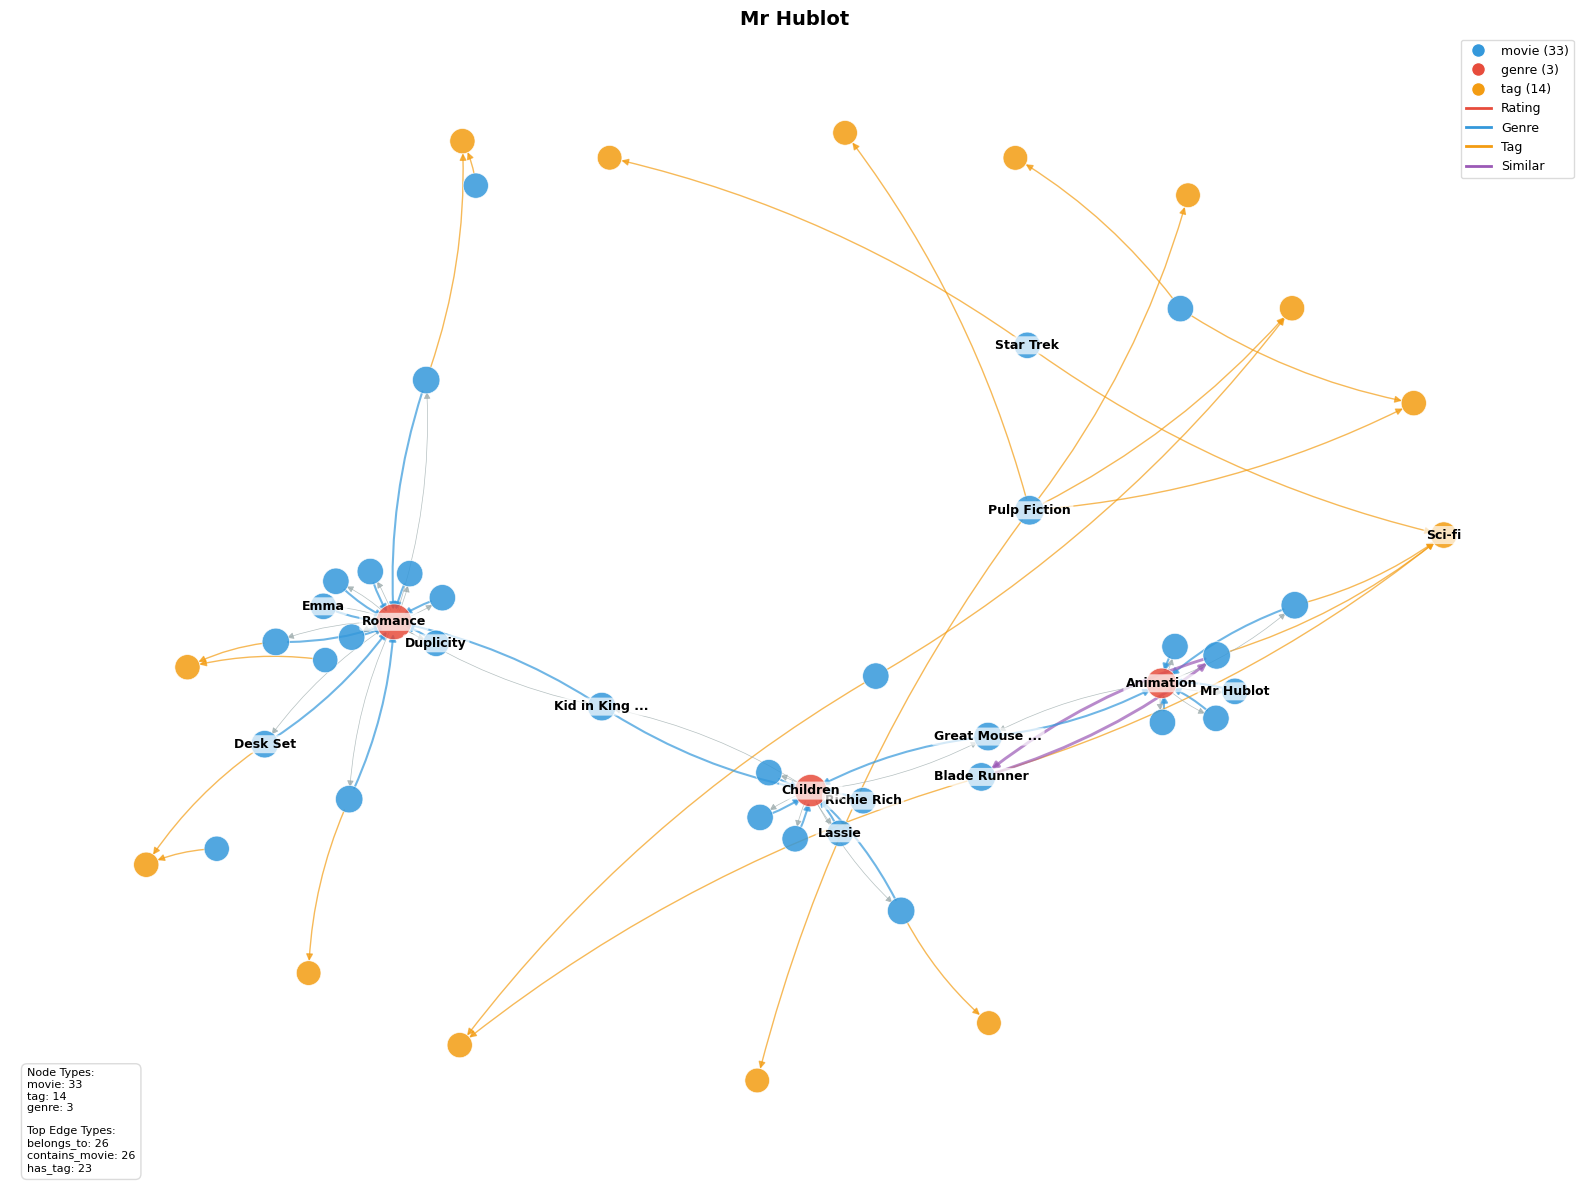

In [18]:
visualize_connected_sample(G, sample_size=50)

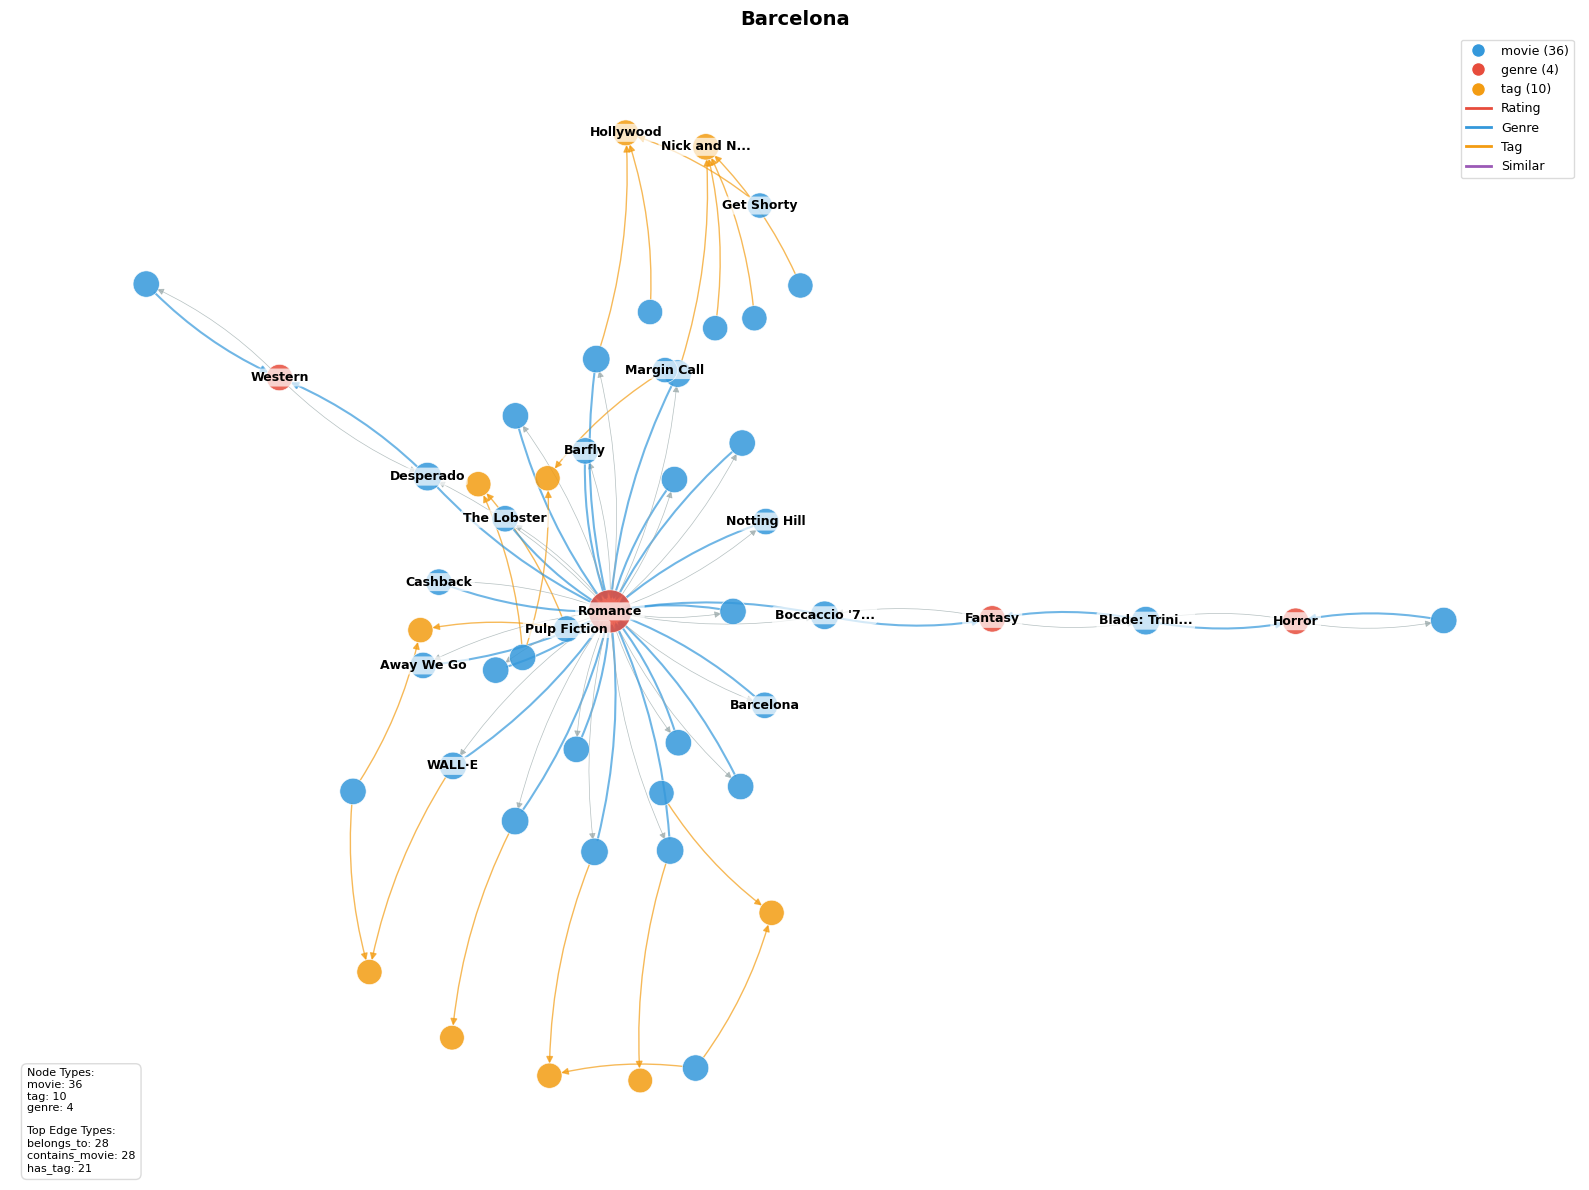

In [19]:
visualize_connected_sample(G, sample_size=50, layout='kamada_kawai')

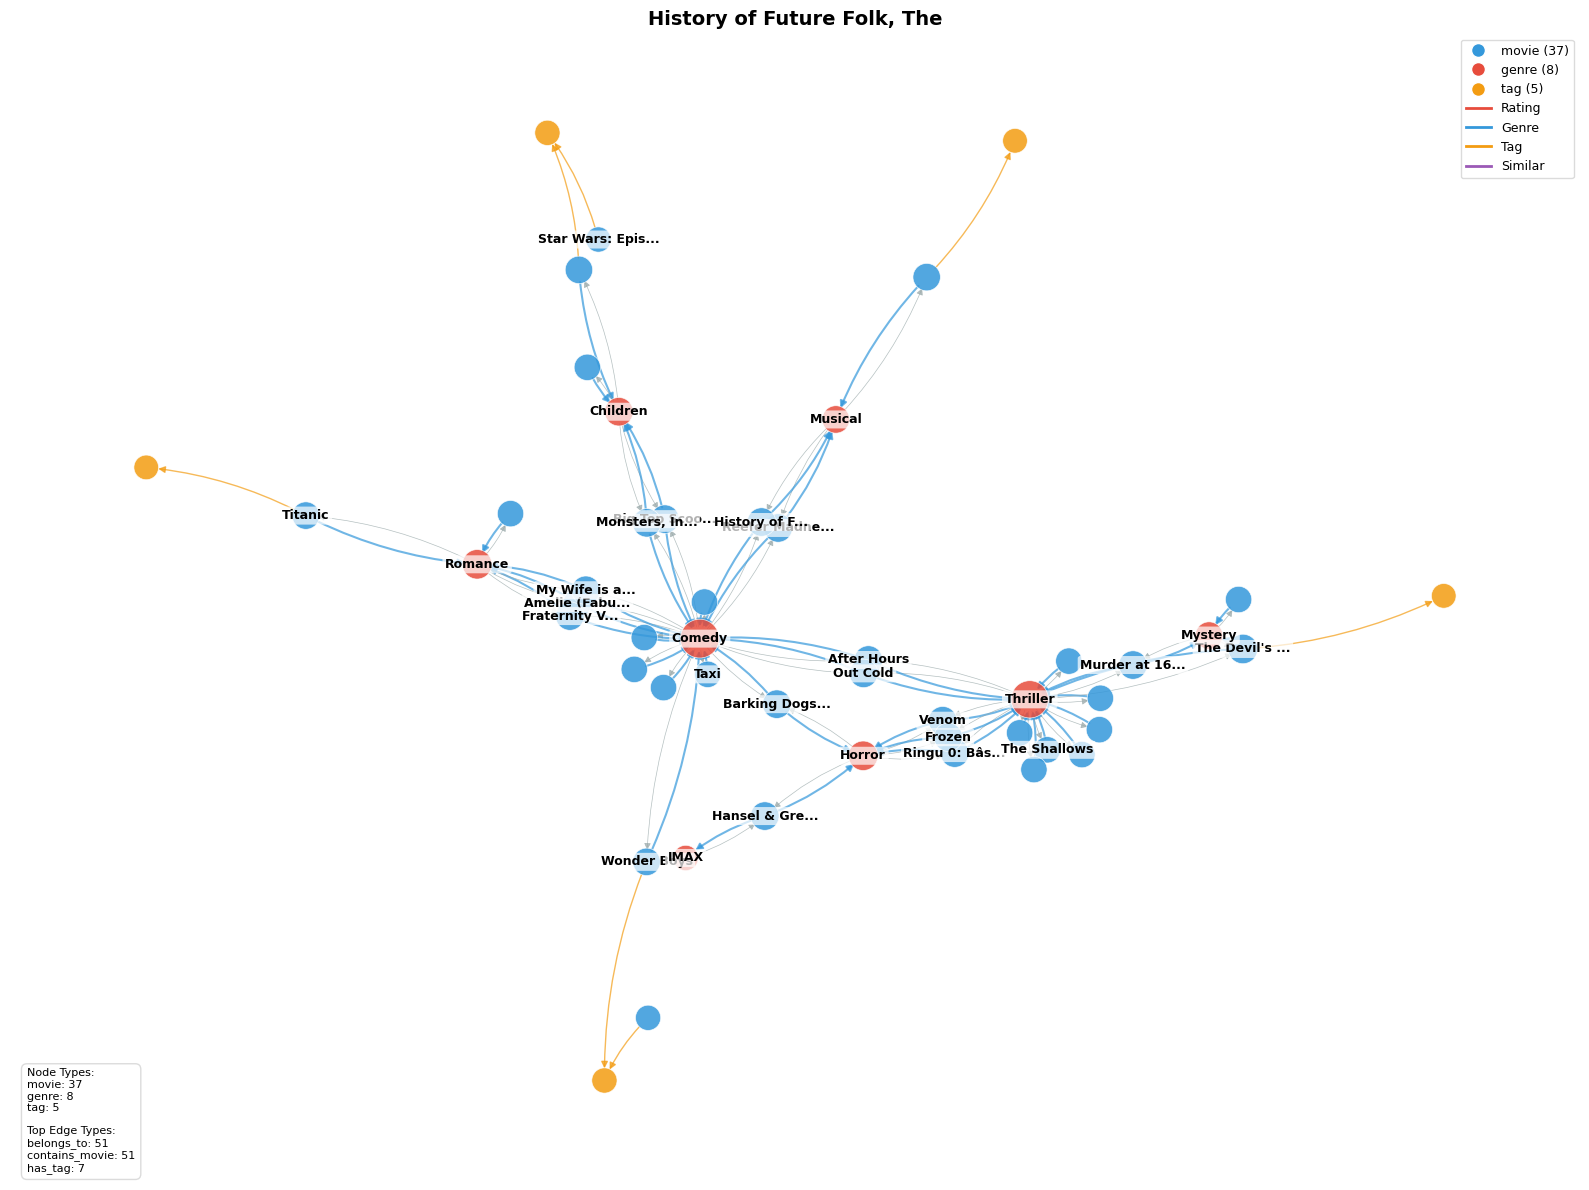

In [20]:
movie_id = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'movie' and 'title' in attr and 'Star Wars' in attr['title']][0]
visualize_connected_sample(G, start_node=movie_id, sample_size=50)

# Step 3: Persist the Graph in ArangoDB


In [52]:
def convert_numpy_types(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

for node, attrs in G.nodes(data=True):
    for key, value in attrs.items():
        G.nodes[node][key] = convert_numpy_types(value)

for u, v, k, attrs in G.edges(data=True, keys=True):
    for key, value in attrs.items():
        G.edges[u, v, k][key] = convert_numpy_types(value)

print("Uploading graph to ArangoDB...")
G_adb = nxadb.Graph(
    name="MovieLens",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000
)

Uploading graph to ArangoDB...


[19:31:43 +0000] [INFO]: Graph 'MovieLens' created.
INFO:nx_arangodb:Graph 'MovieLens' created.
[2025/03/08 19:31:45 +0000] [420] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/08 19:31:52 +0000] [420] [INFO] - adbnx_adapter: Created ArangoDB 'MovieLens' Graph
INFO:adbnx_adapter:Created ArangoDB 'MovieLens' Graph


In [21]:
G_adb = nxadb.MultiDiGraph(name="MovieLens", db=db)

[18:26:47 +0000] [INFO]: Graph 'MovieLens' exists.
INFO:nx_arangodb:Graph 'MovieLens' exists.
[18:26:47 +0000] [INFO]: Default node type set to 'MovieLens_node'
INFO:nx_arangodb:Default node type set to 'MovieLens_node'


In [22]:
# verify data
def sample_nodes_by_type(node_type, limit=3):
    result = G_adb.query(f"""
        FOR node IN MovieLens_node
            FILTER node.type == '{node_type}'
            SORT RAND()
            LIMIT {limit}
            RETURN node
    """)
    return list(result)

print("Sample Movie Nodes:")
print(sample_nodes_by_type('movie'))
print("\nSample User Nodes:")
print(sample_nodes_by_type('user'))
print("\nSample Genre Nodes:")
print(sample_nodes_by_type('genre'))

Sample Movie Nodes:
[{'_key': '3777', '_id': 'MovieLens_node/3777', '_rev': '_jVa8-xi--S', 'type': 'movie', 'title': 'Impromptu', 'original_title': 'Impromptu (1991)', 'year': 1991, 'original_id': 5279, 'embedding_placeholder': None, 'popularity': 2}, {'_key': '4400', '_id': 'MovieLens_node/4400', '_rev': '_jVa8-x6--a', 'type': 'movie', 'title': 'Mississippi Masala', 'original_title': 'Mississippi Masala (1991)', 'year': 1991, 'original_id': 6466, 'embedding_placeholder': None, 'popularity': 3}, {'_key': '5868', '_id': 'MovieLens_node/5868', '_rev': '_jVa8-yy--1', 'type': 'movie', 'title': 'Trip to the Moon, A (Voyage dans la lune, Le)', 'original_title': 'Trip to the Moon, A (Voyage dans la lune, Le) (1902)', 'year': 1902, 'original_id': 32898, 'embedding_placeholder': None, 'popularity': 5}]

Sample User Nodes:
[{'_key': '10041', '_id': 'MovieLens_node/10041', '_rev': '_jVa8-5C-_O', 'type': 'user', 'original_id': 300, 'rating_count': 32, 'avg_rating': 4.296875, 'first_rating': 142535

In [23]:
# Sample edges by type
def sample_edges_by_type(edge_type, limit=3):
    result = G_adb.query(f"""
        FOR edge IN MovieLens_node_to_MovieLens_node
            FILTER edge.type == '{edge_type}'
            SORT RAND()
            LIMIT {limit}
            RETURN edge
    """)
    return list(result)

print("\nSample Rating Edges:")
print(sample_edges_by_type('rated'))
print("\nSample Genre Edges:")
print(sample_edges_by_type('belongs_to'))
print("\nSample Similarity Edges:")
print(sample_edges_by_type('similar_to'))


Sample Rating Edges:
[{'_key': '121830', '_id': 'MovieLens_node_to_MovieLens_node/121830', '_from': 'MovieLens_node/20022', '_to': 'MovieLens_node/20249', '_rev': '_jVa8HRK--W', 'type': 'rated', 'rating': 2.5, 'normalized_rating': 0.375, 'timestamp': 1461945772, 'normalized_time': 0.8931151343742193, 'period': 'late'}, {'_key': '138005', '_id': 'MovieLens_node_to_MovieLens_node/138005', '_from': 'MovieLens_node/21181', '_to': 'MovieLens_node/19106', '_rev': '_jVa8JhW--N', 'type': 'rated', 'rating': 4, 'normalized_rating': 0.75, 'timestamp': 1469675570, 'normalized_time': 0.9040071651990211, 'period': 'late'}, {'_key': '138951', '_id': 'MovieLens_node_to_MovieLens_node/138951', '_from': 'MovieLens_node/21217', '_to': 'MovieLens_node/16486', '_rev': '_jVa8Jnm--L', 'type': 'rated', 'rating': 3.5, 'normalized_rating': 0.625, 'timestamp': 1441845064, 'normalized_time': 0.8647912983391326, 'period': 'late'}]

Sample Genre Edges:
[{'_key': '14130', '_id': 'MovieLens_node_to_MovieLens_node/14

In [24]:
def simple_graph_example():
    output = []

    # Print node types with examples
    output.append("NODE TYPES:")
    node_types = set()
    for _, attrs in G.nodes(data=True):
        if 'type' in attrs and attrs['type'] is not None:
            node_types.add(attrs['type'])

    for node_type in sorted(node_types):
        output.append(f"\n- {node_type} EXAMPLES:")
        count = 0
        for node, attrs in G.nodes(data=True):
            if attrs.get('type') == node_type and count < 2:
                output.append(f"  • {node}: {attrs}")
                count += 1

    # Print edge types with examples
    output.append("\nEDGE TYPES:")
    edge_types = set()
    for _, _, attrs in G.edges(data=True):
        if 'type' in attrs and attrs['type'] is not None:
            edge_types.add(attrs['type'])

    for edge_type in sorted(edge_types):
        output.append(f"\n- {edge_type} EXAMPLES:")
        count = 0
        for source, target, attrs in G.edges(data=True):
            if attrs.get('type') == edge_type and count < 2:
                output.append(f"  • {source} → {target}: {attrs}")
                count += 1

    return "\n".join(output)  # Return as a single string

# Store the result in a variable
graph_info = simple_graph_example()

# Print or use the variable as needed
print(graph_info)

NODE TYPES:

- genre EXAMPLES:
  • genre_adventure: {'type': 'genre', 'name': 'Adventure', 'movie_count': 1263}
  • genre_animation: {'type': 'genre', 'name': 'Animation', 'movie_count': 611}

- movie EXAMPLES:
  • movie_1: {'type': 'movie', 'title': 'Toy Story', 'original_title': 'Toy Story (1995)', 'year': 1995, 'original_id': 1, 'embedding_placeholder': None, 'popularity': 215}
  • movie_2: {'type': 'movie', 'title': 'Jumanji', 'original_title': 'Jumanji (1995)', 'year': 1995, 'original_id': 2, 'embedding_placeholder': None, 'popularity': 110}

- tag EXAMPLES:
  • tag_funny: {'type': 'tag', 'name': 'Funny', 'frequency': 1}
  • tag_highly_quotable: {'type': 'tag', 'name': 'Highly quotable', 'frequency': 3}

- user EXAMPLES:
  • user_1: {'type': 'user', 'original_id': 1, 'rating_count': 232, 'avg_rating': 4.366379310344827, 'first_rating': 964980499, 'last_rating': 965719662, 'activity_duration': 739163}
  • user_2: {'type': 'user', 'original_id': 2, 'rating_count': 29, 'avg_rating': 

In [25]:
graph_info

"NODE TYPES:\n\n- genre EXAMPLES:\n  • genre_adventure: {'type': 'genre', 'name': 'Adventure', 'movie_count': 1263}\n  • genre_animation: {'type': 'genre', 'name': 'Animation', 'movie_count': 611}\n\n- movie EXAMPLES:\n  • movie_1: {'type': 'movie', 'title': 'Toy Story', 'original_title': 'Toy Story (1995)', 'year': 1995, 'original_id': 1, 'embedding_placeholder': None, 'popularity': 215}\n  • movie_2: {'type': 'movie', 'title': 'Jumanji', 'original_title': 'Jumanji (1995)', 'year': 1995, 'original_id': 2, 'embedding_placeholder': None, 'popularity': 110}\n\n- tag EXAMPLES:\n  • tag_funny: {'type': 'tag', 'name': 'Funny', 'frequency': 1}\n  • tag_highly_quotable: {'type': 'tag', 'name': 'Highly quotable', 'frequency': 3}\n\n- user EXAMPLES:\n  • user_1: {'type': 'user', 'original_id': 1, 'rating_count': 232, 'avg_rating': 4.366379310344827, 'first_rating': 964980499, 'last_rating': 965719662, 'activity_duration': 739163}\n  • user_2: {'type': 'user', 'original_id': 2, 'rating_count': 2

# Step 4: GraphRAG Agent

In [26]:
import os
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

In [27]:
arango_graph = ArangoGraph(db)
llm = ChatAnthropic(temperature=0, model_name="claude-3-5-haiku-latest")

In [28]:
@tool
def text_to_aql_to_text(query: str):
    """
    Translates a natural language query into AQL, executes it against the MovieLens graph,
    and returns the results in natural language.
    """
    # Generate AQL from natural language query
    aql_system_prompt = f"""
    You are an expert in translating natural language to ArangoDB AQL queries.

    The MovieLens graph has the following structure:
    {graph_info}

    all edges are stored in a single collection called MovieLens_node_to_MovieLens_node with a type attribute to distinguish different relationships.

    Your task is to return ONLY a valid AQL query without any explanation.
    """

    # Generate AQL query from natural language
    aql_messages = [
        {"role": "system", "content": aql_system_prompt},
        {"role": "user", "content": f"Create an AQL query for: {query}"}
    ]
    aql_response = llm.invoke(aql_messages)

    # Extract AQL query from response (handling possible markdown code blocks)
    aql_query = aql_response.content.strip()
    if "```aql" in aql_query:
        aql_query = aql_query.split("```aql")[1].split("```")[0].strip()
    elif "```" in aql_query:
        aql_query = aql_query.split("```")[1].split("```")[0].strip()

    try:
        # Execute the AQL query directly
        result = G_adb.query(aql_query)
        print("query", aql_query)
        result_data = list(result)
        print("Raw Results from ArangoDB", result_data)
        # Format the results as natural language
        nl_format_prompt = """
        You are an expert in explaining database query results in natural language.

        The following data is the result of a query about movies from the MovieLens database.
        Convert these results into a clear, natural language response.

        Original query: {query}

        Results: {results}

        Respond as if directly to the user who asked: "{query}"
        """

        format_messages = [
            {"role": "system", "content": nl_format_prompt.format(query=query, results=result_data)},
            {"role": "user", "content": "Format these results as a natural language response"}
        ]

        final_response = llm.invoke(format_messages)
        return final_response.content

    except Exception as e:
        return f"Error executing query: {str(e)}\n\nGenerated AQL query: {aql_query}"

In [29]:
result = text_to_aql_to_text("I want to see movies similar to Toy Story")
print(result)

<ipython-input-29-2b51640159e7>:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = text_to_aql_to_text("I want to see movies similar to Toy Story")


query LET toyStory = (
    FOR movie IN MovieLens_node
    FILTER movie.type == 'movie' AND movie.title == 'Toy Story'
    RETURN movie._id
)[0]

FOR similarMovie, edge IN 1..1 OUTBOUND toyStory MovieLens_node_to_MovieLens_node
FILTER edge.type == 'similar_to'
SORT edge.similarity DESC
RETURN {
    movie: similarMovie,
    similarity: edge.similarity
}
Raw Results from ArangoDB [{'movie': {'_key': '3194', '_id': 'MovieLens_node/3194', '_rev': '_jVa8-x---S', 'type': 'movie', 'title': 'Shrek', 'original_title': 'Shrek (2001)', 'year': 2001, 'original_id': 4306, 'embedding_placeholder': None, 'popularity': 170}, 'similarity': 0.54}, {'movie': {'_key': '4360', '_id': 'MovieLens_node/4360', '_rev': '_jVa8-x2-_U', 'type': 'movie', 'title': 'Finding Nemo', 'original_title': 'Finding Nemo (2003)', 'year': 2003, 'original_id': 6377, 'embedding_placeholder': None, 'popularity': 141}, 'similarity': 0.5}]
Based on your interest in movies similar to Toy Story, I have two great recommendations for y

In [30]:
result = text_to_aql_to_text("What are the top 5 most popular comedy movies?")
print(result)

query LET comedyMovies = (
    FOR g IN MovieLens_node_to_MovieLens_node
    FILTER g.type == 'belongs_to' 
    FILTER g._to == 'genre/genre_comedy'
    RETURN g._from
)
FOR movie IN MovieLens_node_to_MovieLens_node
FILTER movie._from IN comedyMovies
FILTER movie.type == 'contains_movie'
SORT movie._to.popularity DESC
LIMIT 5
RETURN {
    title: movie._to.title,
    popularity: movie._to.popularity
}
Raw Results from ArangoDB []
I apologize, but it seems that the query results are empty. Based on the empty list `[]`, I cannot provide specific movie recommendations. 

In this case, I would respond to the user:

"I'm sorry, but I couldn't find any comedy movies in the top 5 most popular list. This could be due to several reasons:
- The database might be empty
- There might be an issue with the query
- No comedy movies met the popularity criteria

Would you like me to help you refine the search or try a different query?"


In [31]:
result = text_to_aql_to_text("Find users who rated more than 100 movies with an average rating above 4.0")
print(result)

query FOR user IN MovieLens_node
    FILTER user.type == 'user' 
    AND user.rating_count > 100 
    AND user.avg_rating > 4.0
RETURN user
Raw Results from ArangoDB [{'_key': '9742', '_id': 'MovieLens_node/9742', '_rev': '_jVa8-42-_V', 'type': 'user', 'original_id': 1, 'rating_count': 232, 'avg_rating': 4.366379310344827, 'first_rating': 964980499, 'last_rating': 965719662, 'activity_duration': 739163}, {'_key': '9758', '_id': 'MovieLens_node/9758', '_rev': '_jVa8-46--H', 'type': 'user', 'original_id': 17, 'rating_count': 105, 'avg_rating': 4.20952380952381, 'first_rating': 1305696226, 'last_rating': 1326943248, 'activity_duration': 21247022}, {'_key': '9784', '_id': 'MovieLens_node/9784', '_rev': '_jVa8-46--h', 'type': 'user', 'original_id': 43, 'rating_count': 114, 'avg_rating': 4.552631578947368, 'first_rating': 848993627, 'last_rating': 848995341, 'activity_duration': 1714}, {'_key': '9793', '_id': 'MovieLens_node/9793', '_rev': '_jVa8-46--q', 'type': 'user', 'original_id': 52, 'r

In [32]:
result = text_to_aql_to_text("Show me movies with the tag 'dystopian' released after 2010")
print(result)

query LET dystopian_movies = (
    FOR m IN MovieLens_node_to_MovieLens_node
    FILTER m.type == 'has_tag'
    LET tag = DOCUMENT(m._to)
    FILTER tag.name == 'dystopian'
    LET movie = DOCUMENT(m._from)
    FILTER movie.year > 2010
    RETURN DISTINCT movie
)
RETURN dystopian_movies
Raw Results from ArangoDB [[]]
I apologize, but it seems that the query results are empty (represented by [[]]). This means that no movies matching the criteria of being tagged as 'dystopian' and released after 2010 were found in the database.

I would respond to the user like this:

"I'm sorry, but I couldn't find any dystopian movies in the database that were released after 2010. This could mean a few things:
- There might not be any movies with the 'dystopian' tag in the database
- There might be dystopian movies, but none released after 2010
- The tag might be entered differently or not exist in the current database

Would you like to try a broader search, such as looking for dystopian movies withou

In [33]:
result = text_to_aql_to_text("Find movies that share at least 3 genres with 'The Matrix'")
print(result)

query LET matrixGenres = (
    FOR g IN MovieLens_node_to_MovieLens_node
    FILTER g._to.type == 'genre' AND g._from.title == 'The Matrix'
    RETURN g._to._id
)

FOR movie IN MovieLens_node_to_MovieLens_node
    FILTER movie._from.type == 'movie' 
    AND movie._to.type == 'genre'
    AND movie._from.title != 'The Matrix'
    LET movieGenres = (
        FOR g IN MovieLens_node_to_MovieLens_node
        FILTER g._to.type == 'genre' AND g._from._id == movie._from._id
        RETURN g._to._id
    )
    LET sharedGenres = INTERSECTION(matrixGenres, movieGenres)
    FILTER LENGTH(sharedGenres) >= 3
    RETURN DISTINCT movie._from
Raw Results from ArangoDB []
I apologize, but the query did not return any results. This means that no movies were found that share at least 3 genres with 'The Matrix'. 

This could be due to a few reasons:
1. The genre matching criteria might be too strict
2. There might be an issue with the database query
3. 'The Matrix' might have a unique combination of genre

In [34]:
result = text_to_aql_to_text("What are the most popular movies from the 1990s?")
print(result)

query FOR movie IN MovieLens_node
    FILTER movie.type == 'movie' AND movie.year >= 1990 AND movie.year < 2000
    SORT movie.popularity DESC
    LIMIT 10
    RETURN {
        title: movie.title,
        year: movie.year,
        popularity: movie.popularity
    }
Raw Results from ArangoDB [{'title': 'Forrest Gump', 'year': 1994, 'popularity': 329}, {'title': 'Shawshank Redemption, The', 'year': 1994, 'popularity': 317}, {'title': 'Pulp Fiction', 'year': 1994, 'popularity': 307}, {'title': 'Silence of the Lambs, The', 'year': 1991, 'popularity': 279}, {'title': 'Matrix, The', 'year': 1999, 'popularity': 278}, {'title': 'Jurassic Park', 'year': 1993, 'popularity': 238}, {'title': 'Braveheart', 'year': 1995, 'popularity': 237}, {'title': 'Terminator 2: Judgment Day', 'year': 1991, 'popularity': 224}, {'title': "Schindler's List", 'year': 1993, 'popularity': 220}, {'title': 'Fight Club', 'year': 1999, 'popularity': 218}]
Based on the query results, here are the most popular movies from t

In [35]:
result = text_to_aql_to_text("Which genres have the highest average user ratings?")
print(result)

Error executing query: [HTTP 400][ERR 1541] invalid number of arguments for function 'DOCUMENT()', expected number of arguments: minimum: 1, maximum: 2

Generated AQL query: WITH genres, movies, rated
FOR g IN genre
LET avg_rating = (
    FOR m IN movie
    FILTER m.type == 'movie'
    FILTER DOCUMENT(MovieLens_node_to_MovieLens_node, m._id, g._id).type == 'belongs_to'
    LET movie_ratings = (
        FOR r IN rated
        FILTER r._to == m._id
        RETURN r.rating
    )
    RETURN AVG(movie_ratings)
)
SORT avg_rating DESC
LIMIT 10
RETURN {
    genre: g.name,
    average_rating: avg_rating
}


In [36]:
result = text_to_aql_to_text("Find movies similar to 'Jurassic Park' with similarity score above 0.6")
print(result)

query LET jurassicPark = (
    FOR movie IN MovieLens_node
    FILTER movie.title == 'Jurassic Park'
    RETURN movie._id
)[0]

FOR similarMovie, edge IN OUTBOUND jurassicPark MovieLens_node_to_MovieLens_node
FILTER edge.type == 'similar_to' AND edge.similarity > 0.6
RETURN DISTINCT similarMovie
Raw Results from ArangoDB [{'_key': '615', '_id': 'MovieLens_node/615', '_rev': '_jVa8-ry--J', 'type': 'movie', 'title': 'Independence Day (a.k.a. ID4)', 'original_title': 'Independence Day (a.k.a. ID4) (1996)', 'year': 1996, 'original_id': 780, 'embedding_placeholder': None, 'popularity': 202}]
Based on your query for movies similar to 'Jurassic Park' with a similarity score above 0.6, I found one notable match:

'Independence Day' (also known as 'ID4') from 1996 appears to be a similar film. This sci-fi blockbuster, like 'Jurassic Park', features large-scale spectacle and was a major hit of the 1990s. The movie stars Will Smith and involves a dramatic alien invasion scenario, which shares som

In [37]:
result = text_to_aql_to_text("Find users who like both sci-fi and romance movies")
print(result)

Error executing query: [HTTP 404][ERR 1203] collection or view not found: genre

Generated AQL query: WITH user, movie, genre
FOR u IN user
    LET sci_fi_movies = (
        FOR m IN movie
            FILTER m.type == 'movie'
            FILTER (FOR g IN genre FILTER g.name == 'Sci-Fi' RETURN g._id IN (
                FOR e IN MovieLens_node_to_MovieLens_node 
                FILTER e._from == m._id AND e.type == 'belongs_to' 
                RETURN e._to
            ))
        FOR rating IN MovieLens_node_to_MovieLens_node
            FILTER rating._from == u._id AND rating._to == m._id AND rating.type == 'rated'
            FILTER rating.normalized_rating > 0.7
        RETURN m
    )
    LET romance_movies = (
        FOR m IN movie
            FILTER m.type == 'movie'
            FILTER (FOR g IN genre FILTER g.name == 'Romance' RETURN g._id IN (
                FOR e IN MovieLens_node_to_MovieLens_node 
                FILTER e._from == m._id AND e.type == 'belongs_to' 
          

## Step 4.1: Complete Recommender Agent Creation

In [31]:
import os
from typing import List, Dict, Any, Union
import re
import json
import random

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_anthropic import ChatAnthropic
from langchain_community.graphs import ArangoGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool

# Import graph libraries
import networkx as nx
import nx_arangodb as nxadb
try:
    import nx_cugraph as nxcg
    HAS_GPU = True
    print("GPU available, using cuGraph for graph algorithms")
except ImportError:
    HAS_GPU = False
    print("GPU not available, falling back to CPU-only mode")

# Define global variables
G_adb = None  # Will be initialized in main function
arango_graph = None  # Will be initialized in main function
llm = None  # Will be initialized in main function

GPU available, using cuGraph for graph algorithms


In [37]:
def create_visualization(data, viz_type="network", title=None):
    """
    Creates a visualization based on the data and type.
    Returns a dict with visualization configuration.
    """
    if viz_type == "network":
        return {
            "type": "network",
            "data": data,
            "title": title or "Network Visualization"
        }
    elif viz_type == "bar":
        return {
            "type": "bar",
            "data": data,
            "title": title or "Bar Chart"
        }
    elif viz_type == "heatmap":
        return {
            "type": "heatmap",
            "data": data,
            "title": title or "Heatmap"
        }
    else:
        return {
            "type": "table",
            "data": data,
            "title": title or "Data Table"
        }


In [38]:
@tool
def text_to_aql_to_text(query: str) -> str:
    """
    Translates a natural language query into AQL, executes it against the MovieLens graph,
    and returns the results in natural language with visualization when appropriate.
    """
    global G_adb, llm, arango_graph

    movie_titles = extract_movie_titles(query)

    if any(word in query.lower() for word in ["similar", "like", "related"]) and movie_titles:
        primary_movie = movie_titles[0]  # Take the first movie title
        return handle_similar_movies_query(primary_movie)
    elif any(genre in query.lower() for genre in ["comedy", "action", "drama", "horror", "sci-fi"]):
        genres = []
        for genre in ["comedy", "action", "drama", "horror", "sci-fi", "thriller", "romance", "animation"]:
            if genre in query.lower():
                genres.append(genre)
        if genres:
            return handle_genre_query(genres[0], "top" in query.lower() or "best" in query.lower())

    elif any(period in query.lower() for period in ["90s", "80s", "2000s", "1990"]):
        years = re.findall(r'\b(19\d0s|20\d0s|\d{4})\b', query)
        if years:
            return handle_year_query(years[0])
    return standard_query_processing(query)

def extract_movie_titles(query):
    """Extract potential movie titles from a query using common patterns"""
    common_titles = {
        "toy story": ["toy story", "toy stories", "toystory", "toy storey"],
        "star wars": ["star wars", "starwars", "star war"],
        "the matrix": ["matrix", "the matrix"],
        "jurassic park": ["jurassic park", "jurassic"],
        "pulp fiction": ["pulp fiction", "pulpfiction"],
        "the godfather": ["godfather", "the godfather"],
        "titanic": ["titanic"],
        "inception": ["inception"],
        "avatar": ["avatar"],
        "the dark knight": ["dark knight", "the dark knight", "batman dark knight"]
    }

    # Check for common titles with fuzzy matching
    found_titles = []
    query_lower = query.lower()

    for standard_title, variations in common_titles.items():
        if any(variation in query_lower for variation in variations):
            found_titles.append(standard_title)

    return found_titles

def handle_similar_movies_query(movie_title):
    """Handle a query about movies similar to a specific movie"""
    try:
        find_movie_query = f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie' AND LOWER(movie.title) LIKE LOWER("%{movie_title}%")
        LIMIT 1
        RETURN movie
        """

        movie_result = list(G_adb.query(find_movie_query))

        if not movie_result:
            find_movie_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie'
            FILTER CONTAINS(LOWER(movie.title), SPLIT(LOWER("{movie_title}"), " ")[0])
            SORT movie.popularity DESC
            LIMIT 1
            RETURN movie
            """
            movie_result = list(G_adb.query(find_movie_query))

        if movie_result:
            source_movie = movie_result[0]
            movie_id = source_movie["_id"]
            similar_movies_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie._id == "{movie_id}"
            LET similar = (
                FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
                FILTER e.type == 'similar_to'
                SORT e.similarity DESC
                LIMIT 10
                RETURN {{
                    movie: v,
                    similarity: e.similarity
                }}
            )
            RETURN {{
                source_movie: movie.title,
                similar_movies: similar
            }}
            """

            similar_result = list(G_adb.query(similar_movies_query))

            if similar_result and similar_result[0].get("similar_movies"):
                # Format the results for visualization
                source_title = similar_result[0]["source_movie"]
                similar_movies = similar_result[0]["similar_movies"]

                # Prepare visualization data
                network_data = {
                    "nodes": [
                        {"id": "source", "label": source_title, "group": "source"}
                    ],
                    "edges": []
                }

                # Add similar movies as nodes and edges
                for i, movie in enumerate(similar_movies):
                    movie_info = movie["movie"]
                    similarity = movie["similarity"]

                    node_id = f"similar_{i}"
                    title = movie_info.get("title", f"Movie {i+1}")

                    network_data["nodes"].append({
                        "id": node_id,
                        "label": title,
                        "group": "similar"
                    })

                    network_data["edges"].append({
                        "from": "source",
                        "to": node_id,
                        "label": f"{similarity:.2f}",
                        "weight": similarity
                    })

                visualization = create_visualization(network_data, "network", f"Movies Similar to {source_title}")
                response_text = f"Here are movies similar to {source_title}:\n\n"
                for movie in similar_movies:
                    title = movie["movie"].get("title", "Unnamed movie")
                    similarity = movie["similarity"]
                    response_text += f"- {title} (similarity: {similarity:.2f})\n"

                return {
                    "text": response_text,
                    "visualization": visualization
                }
            else:
                return handle_similar_movies_by_genre(source_movie)
        else:
            return f"I couldn't find information about '{movie_title}'. Could you check the spelling or try another movie title?"

    except Exception as e:
        print(f"Error in similar movies query: {e}")
        return f"I had trouble finding movies similar to '{movie_title}'. The database might not have information about this movie or its relationships."

def handle_similar_movies_by_genre(source_movie):
    """Fallback method to find similar movies by matching genres"""
    try:
        movie_id = source_movie["_id"]
        movie_title = source_movie.get("title", "this movie")
        genre_query = f"""
        FOR movie IN MovieLens_node
        FILTER movie._id == "{movie_id}"
        LET genres = (
            FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
            FILTER e.type == 'belongs_to' AND v.type == 'genre'
            RETURN v.name
        )
        RETURN {{
            title: movie.title,
            genres: genres
        }}
        """

        genre_result = list(G_adb.query(genre_query))

        if genre_result and genre_result[0].get("genres"):
            genres = genre_result[0]["genres"]
            similar_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie' AND movie._id != "{movie_id}"
            LET movie_genres = (
                FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
                FILTER e.type == 'belongs_to' AND v.type == 'genre'
                RETURN v.name
            )
            LET common_genres = LENGTH(
                FOR genre IN movie_genres
                FILTER genre IN {json.dumps(genres)}
                RETURN genre
            )
            FILTER common_genres > 0
            SORT common_genres DESC, movie.popularity DESC
            LIMIT 10
            RETURN {{
                title: movie.title,
                year: movie.year,
                common_genre_count: common_genres,
                movie_genres: movie_genres
            }}
            """

            similar_result = list(G_adb.query(similar_query))

            if similar_result:
                response_text = f"Based on genres similar to {movie_title} ({', '.join(genres)}), you might enjoy:\n\n"

                for movie in similar_result:
                    title = movie.get("title", "Unnamed movie")
                    year = movie.get("year", "")
                    common_count = movie.get("common_genre_count", 0)
                    movie_genres = movie.get("movie_genres", [])

                    year_str = f" ({year})" if year else ""
                    response_text += f"- {title}{year_str} - Shares {common_count} genres: {', '.join(movie_genres[:3])}\n"

                return response_text

        return f"I couldn't find movies similar to {movie_title} based on available data."

    except Exception as e:
        print(f"Error in genre-based similarity: {e}")
        return f"I had trouble finding movies similar to {source_movie.get('title', 'this movie')} by genre matching."

def handle_genre_query(genre, is_top_rated=False):
    """Handle a query about movies in a specific genre"""
    try:
        if is_top_rated:
            genre_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie'
            LET genres = (
                FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
                FILTER e.type == 'belongs_to' AND v.type == 'genre'
                RETURN v.name
            )
            LET is_target_genre = (
                FOR g IN genres
                FILTER LOWER(g) == LOWER("{genre}")
                RETURN 1
            )
            LET ratings = (
                FOR r IN MovieLens_node_to_MovieLens_node
                FILTER r.type == 'rated' AND r._to == movie._id
                RETURN r.rating
            )
            LET avg_rating = LENGTH(ratings) > 0 ? AVG(ratings) : null
            LET rating_count = LENGTH(ratings)

            FILTER LENGTH(is_target_genre) > 0
            FILTER rating_count >= 5
            FILTER avg_rating != null

            SORT avg_rating DESC
            LIMIT 10

            RETURN {{
                title: movie.title,
                year: movie.year,
                average_rating: avg_rating,
                number_of_ratings: rating_count
            }}
            """
        else:
            genre_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie'
            LET genres = (
                FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
                FILTER e.type == 'belongs_to' AND v.type == 'genre'
                RETURN v.name
            )
            LET is_target_genre = (
                FOR g IN genres
                FILTER LOWER(g) == LOWER("{genre}")
                RETURN 1
            )

            FILTER LENGTH(is_target_genre) > 0
            SORT movie.popularity DESC
            LIMIT 10

            RETURN {{
                title: movie.title,
                year: movie.year,
                genres: genres
            }}
            """

        genre_results = list(G_adb.query(genre_query))

        if genre_results:
            bar_data = []
            for item in genre_results:
                year = item.get('year', '')
                year_str = f" ({year})" if year else ""
                label = f"{item.get('title', 'Unknown')}{year_str}"

                if is_top_rated:
                    value = item.get('average_rating', 0)
                    bar_data.append({'label': label, 'value': value})

            visualization = None
            if is_top_rated and bar_data:
                visualization = create_visualization(bar_data, "bar", f"Top {genre.title()} Movies by Rating")

            response_text = f"{'Top rated' if is_top_rated else 'Popular'} {genre.title()} movies:\n\n"

            for movie in genre_results:
                title = movie.get("title", "Unnamed movie")
                year = movie.get("year", "")
                year_str = f" ({year})" if year else ""

                if is_top_rated:
                    avg_rating = movie.get("average_rating", 0)
                    num_ratings = movie.get("number_of_ratings", 0)
                    response_text += f"- {title}{year_str} - Rating: {avg_rating:.1f} ({num_ratings} ratings)\n"
                else:
                    genres = movie.get("genres", [])
                    genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""
                    response_text += f"- {title}{year_str}{genre_str}\n"

            if visualization:
                return {
                    "text": response_text,
                    "visualization": visualization
                }
            else:
                return response_text
        else:
            return f"I couldn't find any {genre} movies in the database. Would you like to try a different genre?"

    except Exception as e:
        print(f"Error in genre query: {e}")
        return f"I had trouble finding information about {genre} movies. The database might not have information about this genre."

def handle_year_query(year_str):
    """Handle a query about movies from a specific year or decade"""
    try:
        if len(year_str) == 4:
            year = int(year_str)
            start_year = year
            end_year = year
            period_name = str(year)
        else:  # Decade (e.g., "1990s")
            start_year = int(year_str[:4])
            end_year = start_year + 9
            period_name = f"{year_str[:4]}s"

        year_query = f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        FILTER HAS(movie, "year") AND movie.year >= {start_year} AND movie.year <= {end_year}

        LET ratings = (
            FOR r IN MovieLens_node_to_MovieLens_node
            FILTER r.type == 'rated' AND r._to == movie._id
            RETURN r.rating
        )
        LET avg_rating = LENGTH(ratings) > 0 ? AVG(ratings) : null
        LET rating_count = LENGTH(ratings)

        FILTER rating_count > 0

        SORT movie.popularity DESC
        LIMIT 15

        RETURN {{
            title: movie.title,
            year: movie.year,
            popularity: movie.popularity,
            average_rating: avg_rating,
            rating_count: rating_count
        }}
        """

        year_results = list(G_adb.query(year_query))

        if year_results:
            response_text = f"Popular movies from the {period_name}:\n\n"

            for movie in year_results:
                title = movie.get("title", "Unnamed movie")
                year = movie.get("year", "")
                avg_rating = movie.get("average_rating", 0)
                rating_str = f" - Rating: {avg_rating:.1f}" if avg_rating else ""

                response_text += f"- {title} ({year}){rating_str}\n"

            return response_text
        else:
            relaxed_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie'
            FILTER HAS(movie, "year") AND movie.year >= {start_year} AND movie.year <= {end_year}
            SORT movie.popularity DESC
            LIMIT 10
            RETURN {{
                title: movie.title,
                year: movie.year
            }}
            """

            relaxed_results = list(G_adb.query(relaxed_query))

            if relaxed_results:
                response_text = f"Some movies from the {period_name}:\n\n"

                for movie in relaxed_results:
                    title = movie.get("title", "Unnamed movie")
                    year = movie.get("year", "")

                    response_text += f"- {title} ({year})\n"

                return response_text
            else:
                return f"I couldn't find any movies from the {period_name} in the database."

    except Exception as e:
        print(f"Error in year query: {e}")
        return f"I had trouble finding movies from {year_str}. The database might not have comprehensive information for this time period."

def standard_query_processing(query):
    """Process other types of queries using the standard AQL generation approach"""
    aql_system_prompt = f"""
    You are an expert in translating natural language to ArangoDB AQL queries for a MovieLens graph database.

    The MovieLens graph has:
    - Nodes of type 'movie', 'user', 'genre', and 'tag' in collection 'MovieLens_node'
    - Edges in collection 'MovieLens_node_to_MovieLens_node' with types 'rated', 'belongs_to', 'has_tag', 'similar_to'

    CRITICAL REQUIREMENTS:
    1. Use HAS(node, "attribute") before accessing attributes
    2. Use LOWER() for case-insensitive string comparisons
    3. Use proper traversal with FOR v, e IN 1..1 OUTBOUND/INBOUND
    4. Put SORT before RETURN and after FILTER
    5. ROUND() takes only one argument

    Your task is to return ONLY a valid AQL query that will work with this schema.
    """

    aql_messages = [
        {"role": "system", "content": aql_system_prompt},
        {"role": "user", "content": f"Create an AQL query for: {query}"}
    ]
    aql_response = llm.invoke(aql_messages)

    aql_query = aql_response.content.strip()
    if "```aql" in aql_query:
        aql_query = aql_query.split("```aql")[1].split("```")[0].strip()
    elif "```" in aql_query:
        aql_query = aql_query.split("```")[1].split("```")[0].strip()

    try:
        print(f"Executing AQL query: {aql_query}")
        result = G_adb.query(aql_query)
        result_data = list(result)

        # If empty results, try a simpler query
        if not result_data:
            print("No results found, trying simplified query...")
            return handle_empty_results(query)

        nl_format_prompt = f"""
        You are an expert in explaining database query results in natural language.

        The following data is the result of a query about movies from the MovieLens database.
        Convert these results into a clear, natural language response.

        Original query: {query}

        Results: {json.dumps(result_data, default=str)}

        Respond as if directly to the user, keeping your response concise but informative.
        """

        format_messages = [
            {"role": "system", "content": nl_format_prompt},
            {"role": "user", "content": "Format these results as a natural language response"}
        ]

        final_response = llm.invoke(format_messages)
        return final_response.content

    except Exception as e:
        print(f"Error executing AQL query: {str(e)}")

        if "syntax error" in str(e).lower():
            return handle_empty_results(query)

        return f"I couldn't find the information you requested about {query}. Could you try rephrasing your question?"

def handle_empty_results(query):
    """Handle queries that returned no results by using a more general approach"""
    movie_terms = ["movie", "film", "watch", "cinema"]
    genre_terms = ["genre", "category", "type", "comedy", "action", "drama", "horror"]
    rating_terms = ["rate", "rating", "score", "popular", "best", "top", "highest"]

    has_movie_terms = any(term in query.lower() for term in movie_terms)
    has_genre_terms = any(term in query.lower() for term in genre_terms)
    has_rating_terms = any(term in query.lower() for term in rating_terms)

    if has_movie_terms and has_rating_terms:
        simple_query = """
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        SORT movie.popularity DESC
        LIMIT 10
        RETURN {
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null
        }
        """
    elif has_movie_terms and has_genre_terms:
        simple_query = """
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        LET genres = (
            FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
            FILTER e.type == 'belongs_to' AND v.type == 'genre'
            RETURN v.name
        )
        FILTER LENGTH(genres) > 0
        SORT movie.popularity DESC
        LIMIT 10
        RETURN {
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null,
            genres: genres
        }
        """
    else:
        simple_query = """
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        SORT movie.popularity DESC
        LIMIT 10
        RETURN {
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null
        }
        """

    try:
        print(f"Executing simplified query: {simple_query}")
        result = G_adb.query(simple_query)
        result_data = list(result)

        if result_data:
            if has_rating_terms:
                response = "Here are some popular movies you might be interested in:\n\n"
            elif has_genre_terms:
                response = "Here are some movies with their genres:\n\n"
            else:
                response = "Here are some popular movies from the database:\n\n"

            for movie in result_data:
                title = movie.get("title", "Unnamed movie")
                year = movie.get("year", "")
                year_str = f" ({year})" if year else ""

                if has_genre_terms and "genres" in movie:
                    genres = movie.get("genres", [])
                    genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""
                    response += f"- {title}{year_str}{genre_str}\n"
                else:
                    response += f"- {title}{year_str}\n"

            response += "\nI couldn't find exact matches for your query, so I've shown some popular movies instead."
            return response
        else:
            return "I couldn't find any movies matching your query in the database. Could you try a different search?"

    except Exception as e:
        print(f"Error executing simplified query: {str(e)}")
        return "I'm having trouble retrieving movie information from the database right now. Could you try a simpler query or check back later?"

def check_aql_syntax(aql_query):
    """Check AQL query for common syntax issues"""
    issues = []

    # Check for SORT after RETURN
    if re.search(r'RETURN.*SORT', aql_query, re.DOTALL):
        issues.append("SORT statement appears after RETURN - move SORT before RETURN")

    # Check for ROUND with two parameters
    if re.search(r'ROUND\([^,)]+,[^)]+\)', aql_query):
        issues.append("ROUND function has two parameters - only one parameter is allowed")

    # Check for missing HAS checks
    if re.search(r'FILTER\s+\w+\.\w+', aql_query) and not re.search(r'HAS\(\w+,', aql_query):
        issues.append("Missing HAS() checks before accessing node attributes")

    # Check for missing LOWER in string comparisons
    if re.search(r'FILTER.*==.*[\'"]', aql_query) and not re.search(r'LOWER\(', aql_query):
        issues.append("String comparisons should use LOWER() for case insensitivity")

    # Check for incorrect traversal pattern
    if re.search(r'FOR\s+\w+\s+IN\s+OUT', aql_query) and not re.search(r'FOR\s+\w+,\s*\w+\s+IN\s+\d+\.\.\d+\s+(OUTBOUND|INBOUND)', aql_query):
        issues.append("Incorrect traversal pattern - use 'FOR v, e IN 1..1 OUTBOUND/INBOUND'")

    # Check for COLLECT AGGREGATE in subqueries
    if re.search(r'LET.*COLLECT.*AGGREGATE', aql_query):
        issues.append("COLLECT AGGREGATE in subquery - use LENGTH() for counting")

    return issues

def fix_aql_syntax_error(aql_query, error_message):
    """Fix specific AQL syntax errors based on error message"""

    if "syntax error, unexpected SORT" in error_message:
        sort_match = re.search(r'SORT\s+(.+?)(?:\s+LIMIT|\s*$)', aql_query)
        limit_match = re.search(r'LIMIT\s+(\d+)', aql_query)

        if sort_match:
            sort_clause = f"SORT {sort_match.group(1)}"
            aql_query = re.sub(r'SORT\s+.+?(?:\s+LIMIT|\s*$)', '', aql_query)

            return_pos = aql_query.find("RETURN")
            if return_pos != -1:
                aql_query = aql_query[:return_pos] + sort_clause + "\n    " + aql_query[return_pos:]

                if limit_match:
                    limit_clause = f"LIMIT {limit_match.group(1)}"
                    aql_query = re.sub(r'LIMIT\s+\d+', '', aql_query)
                    return_pos = aql_query.find("RETURN")
                    aql_query = aql_query[:return_pos] + sort_clause + "\n    " + limit_clause + "\n    " + aql_query[return_pos:]

    if "invalid number of arguments for function 'ROUND()'" in error_message:
        aql_query = re.sub(r'ROUND\(([^,)]+),\s*[^)]+\)', r'ROUND(\1)', aql_query)

    if "accessing non-existing attribute" in error_message or "unassignable to object attribute" in error_message:
        # Extract the attribute that caused the error
        attr_match = re.search(r'attribute [\'"]?(\w+)[\'"]?', error_message)
        if attr_match:
            attr_name = attr_match.group(1)
            # Find potential objects that might use this attribute
            obj_matches = re.findall(r'(\w+)\.' + attr_name, aql_query)
            for obj in set(obj_matches):
                # Add HAS check before filtering on this attribute
                old_filter = f"FILTER {obj}.{attr_name}"
                new_filter = f"FILTER HAS({obj}, \"{attr_name}\") AND {obj}.{attr_name}"
                aql_query = aql_query.replace(old_filter, new_filter)

    if "invalid document id" in error_message or "collection not found" in error_message:
        # This often happens when a variable is mistaken for a collection
        # Try to identify and fix the issue
        coll_match = re.search(r'collection \'([^\']+)\'', error_message)
        if coll_match:
            problematic_name = coll_match.group(1)
            # If it's a variable that should be a node id
            if problematic_name.lower() in ["movie", "user", "genre", "tag"]:
                aql_query = aql_query.replace(f"IN {problematic_name}", "IN MovieLens_node")

    return aql_query

def relax_query_constraints(aql_query, original_query):
    """Relax constraints in a query that returned no results"""

    if any(genre.lower() in original_query.lower() for genre in ["comedy", "action", "drama", "horror", "sci-fi", "documentary"]):
        for genre in ["comedy", "action", "drama", "horror", "sci-fi", "documentary"]:
            if genre in original_query.lower():
                aql_query = re.sub(
                    r'g\.name\s*==\s*[\'"]' + genre + '[\'"]',
                    f'LOWER(g.name) == "{genre.lower()}"',
                    aql_query,
                    flags=re.IGNORECASE
                )
                aql_query = re.sub(
                    r'v\.name\s*==\s*[\'"]' + genre + '[\'"]',
                    f'LOWER(v.name) == "{genre.lower()}"',
                    aql_query,
                    flags=re.IGNORECASE
                )

    rating_match = re.search(r'rating_count\s*>\s*(\d+)', aql_query)
    if rating_match:
        current_threshold = int(rating_match.group(1))
        if current_threshold > 100:
            new_threshold = max(10, current_threshold // 10)
            aql_query = re.sub(
                r'rating_count\s*>\s*\d+',
                f'rating_count > {new_threshold}',
                aql_query
            )

    year_range_match = re.search(r'movie\.year\s*>=\s*(\d+)\s*AND\s*movie\.year\s*<=\s*(\d+)', aql_query)
    if year_range_match:
        start_year = int(year_range_match.group(1))
        end_year = int(year_range_match.group(2))
        new_start = max(1900, start_year - 5)
        new_end = min(2023, end_year + 5)
        aql_query = re.sub(
            r'movie\.year\s*>=\s*\d+\s*AND\s*movie\.year\s*<=\s*\d+',
            f'movie.year >= {new_start} AND movie.year <= {new_end}',
            aql_query
        )

    limit_match = re.search(r'LIMIT\s+(\d+)', aql_query)
    if limit_match and int(limit_match.group(1)) < 20:
        aql_query = re.sub(r'LIMIT\s+\d+', 'LIMIT 20', aql_query)

    return aql_query

def generate_fallback_query(query, error_message):
    """Generate a simplified fallback query when all else fails"""

    is_about_movies = any(term in query.lower() for term in ["movie", "film", "watch", "cinema"])
    is_about_genres = any(term in query.lower() for term in ["genre", "category", "type", "comedy", "action", "drama", "horror"])
    is_about_ratings = any(term in query.lower() for term in ["rate", "rating", "score", "popular", "best", "top", "highest"])

    years = re.findall(r'\b(19\d0s|20\d0s|\d{4})\b', query)

    genres = []
    for genre in ["comedy", "action", "drama", "horror", "sci-fi", "thriller", "documentary", "romance", "animation"]:
        if genre in query.lower():
            genres.append(genre)

    # Build a robust fallback query
    if is_about_movies and is_about_genres and genres:
        genre = genres[0]  # Take the first genre found
        return f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        LET genres = (
            FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
            FILTER v.type == 'genre' AND e.type == 'belongs_to'
            RETURN v.name
        )
        FILTER POSITION(genres, g => LOWER(g) == "{genre.lower()}") != -1
        SORT movie.popularity DESC
        LIMIT 15
        RETURN {{
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null,
            genres: genres
        }}
        """

    elif is_about_movies and years:
        year_str = years[0]
        if len(year_str) == 4:  # Specific year
            year = int(year_str)
            start_year = year
            end_year = year
        else:  # Decade (e.g., "1990s")
            start_year = int(year_str[:4])
            end_year = start_year + 9

        return f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        FILTER HAS(movie, "year") AND movie.year >= {start_year} AND movie.year <= {end_year}
        SORT movie.popularity DESC
        LIMIT 15
        RETURN {{
            title: movie.title,
            year: movie.year
        }}
        """

    elif is_about_movies and is_about_ratings:
        return """
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        LET ratings = (
            FOR r IN MovieLens_node_to_MovieLens_node
            FILTER r.type == 'rated' AND r._to == movie._id
            RETURN r.rating
        )
        LET avg_rating = LENGTH(ratings) > 0 ? AVG(ratings) : null
        LET rating_count = LENGTH(ratings)
        FILTER rating_count >= 10
        FILTER avg_rating != null
        SORT avg_rating DESC
        LIMIT 15
        RETURN {
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null,
            average_rating: avg_rating,
            number_of_ratings: rating_count
        }
        """

    else:
        return """
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        SORT movie.popularity DESC
        LIMIT 15
        RETURN {
            title: movie.title,
            year: HAS(movie, "year") ? movie.year : null
        }
        """
#######################################################################

import networkx as nx
import numpy as np
import pandas as pd
import json
import time
import re
from functools import lru_cache
from typing import List, Dict, Any, Tuple, Optional, Union

# Try to import GPU-accelerated graph libraries with fallbacks
try:
    import cugraph
    import cudf
    HAS_GPU = True
except ImportError:
    HAS_GPU = False

# Try to import NetworkX-based GPU acceleration (nx_cugraph)
try:
    import nx_cugraph
    HAS_NX_CUGRAPH = True
except ImportError:
    HAS_NX_CUGRAPH = False

# Define a graph sampling function to improve performance
def sample_graph_for_task(G, task_type, size=5000, relevant_nodes=None):
    """Sample a subgraph based on the analytics task

    Args:
        G: The full NetworkX graph
        task_type: String indicating the analysis type ('centrality', 'community', 'pagerank', etc.)
        size: Maximum number of nodes to include in sample
        relevant_nodes: List of node IDs that must be included (e.g., specific movies)

    Returns:
        A sampled NetworkX graph
    """
    if G.number_of_nodes() <= size:
        return G  # No sampling needed

    if relevant_nodes is None:
        relevant_nodes = []

    sampled_nodes = set(relevant_nodes)

    # Add nodes based on task requirements
    if task_type == 'centrality':
        # For centrality, prioritize high-degree nodes
        degrees = dict(G.degree())
        high_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:size]
        sampled_nodes.update([node for node, _ in high_degree_nodes])

    elif task_type == 'community':
        # For community detection, use a snowball sampling approach
        if relevant_nodes:
            frontier = list(relevant_nodes)
        else:
            # Start with some high-degree nodes if no relevant nodes provided
            degrees = dict(G.degree())
            seeds = [node for node, _ in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]]
            frontier = seeds

        while len(sampled_nodes) < size and frontier:
            current = frontier.pop(0)
            if current not in sampled_nodes:
                sampled_nodes.add(current)
                neighbors = list(G.neighbors(current))
                # Randomize neighbor selection
                np.random.shuffle(neighbors)
                frontier.extend(neighbors[:50])  # Limit neighbors to avoid explosion

    elif task_type == 'pagerank':
        # For PageRank, include high out-degree nodes and their connections
        if relevant_nodes:
            sampled_nodes.update(relevant_nodes)
            # Add neighborhoods of relevant nodes
            for node in relevant_nodes:
                if node in G:
                    sampled_nodes.update(G.neighbors(node))

        # Fill remaining with high-degree nodes
        if len(sampled_nodes) < size:
            degrees = dict(G.degree())
            remaining = size - len(sampled_nodes)
            high_degree_nodes = [node for node, _ in sorted(degrees.items(),
                                key=lambda x: x[1], reverse=True)
                                if node not in sampled_nodes][:remaining]
            sampled_nodes.update(high_degree_nodes)

    else:  # Default random sampling
        if len(sampled_nodes) < size:
            all_nodes = list(G.nodes())
            np.random.shuffle(all_nodes)
            remaining = size - len(sampled_nodes)
            sampled_nodes.update(all_nodes[:remaining])

    # Create the subgraph
    return G.subgraph(list(sampled_nodes)).copy()

# Cache the converted NetworkX graph to avoid repeated conversions
@lru_cache(maxsize=1)
def get_networkx_graph(arangodb_graph):
    """Convert ArangoDB graph to NetworkX format with caching"""
    print("Converting ArangoDB graph to NetworkX...")
    start_time = time.time()

    G = nx.DiGraph()

    # Query nodes first
    node_query = """
    FOR node IN MovieLens_node
    RETURN {
        id: node._id,
        type: node.type,
        properties: node
    }
    """

    nodes = list(arangodb_graph.query(node_query))

    # Add nodes to NetworkX graph
    for node in nodes:
        properties = node['properties']
        node_id = node['id']
        G.add_node(node_id, **properties)

    # Query edges
    edge_query = """
    FOR edge IN MovieLens_node_to_MovieLens_node
    RETURN {
        source: edge._from,
        target: edge._to,
        type: edge.type,
        properties: edge
    }
    """

    edges = list(arangodb_graph.query(edge_query))

    # Add edges to NetworkX graph
    for edge in edges:
        source = edge['source']
        target = edge['target']
        properties = edge['properties']
        G.add_edge(source, target, **properties)

    print(f"Converted graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges in {time.time() - start_time:.2f} seconds")
    return G

# Function to extract movie IDs from a query
def extract_movie_ids(arangodb_graph, query_text):
    """Extract movie IDs mentioned in the query text"""
    # First try to extract movie titles
    movie_titles = []

    # Look for quoted movie titles
    quoted_titles = re.findall(r'"([^"]+)"', query_text)
    movie_titles.extend(quoted_titles)

    common_titles = {
        "toy story": ["toy story", "toy stories", "toystory", "toy storey"],
        "star wars": ["star wars", "starwars", "star war"],
        "the matrix": ["matrix", "the matrix"],
        "jurassic park": ["jurassic park", "jurassic"],
        "pulp fiction": ["pulp fiction", "pulpfiction"],
        "the godfather": ["godfather", "the godfather"],
        "titanic": ["titanic"],
        "inception": ["inception"],
        "avatar": ["avatar"],
        "the dark knight": ["dark knight", "the dark knight", "batman dark knight"]
    }

    # Check for common titles
    query_lower = query_text.lower()
    for standard_title, variations in common_titles.items():
        if any(variation in query_lower for variation in variations):
            movie_titles.append(standard_title)

    # Now lookup the movie IDs
    movie_ids = []
    if movie_titles:
        for title in movie_titles:
            find_movie_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie.type == 'movie' AND LOWER(movie.title) LIKE LOWER("%{title}%")
            LIMIT 1
            RETURN movie._id
            """

            result = list(arangodb_graph.query(find_movie_query))
            if result:
                movie_ids.append(result[0])

    return movie_ids

# Extract genre information from a query
def extract_genre_info(arangodb_graph, query_text):
    """Extract genre information from the query text"""
    common_genres = [
        "action", "adventure", "animation", "children", "comedy",
        "crime", "documentary", "drama", "fantasy", "film-noir",
        "horror", "musical", "mystery", "romance", "sci-fi",
        "thriller", "war", "western"
    ]

    found_genres = []
    query_lower = query_text.lower()

    for genre in common_genres:
        if genre in query_lower:
            found_genres.append(genre)

    # Get genre node IDs if genres were found
    genre_ids = []
    if found_genres:
        for genre in found_genres:
            find_genre_query = f"""
            FOR genre IN MovieLens_node
            FILTER genre.type == 'genre' AND LOWER(genre.name) == LOWER("{genre}")
            LIMIT 1
            RETURN genre._id
            """

            result = list(arangodb_graph.query(find_genre_query))
            if result:
                genre_ids.append(result[0])

    return found_genres, genre_ids

# Extract year range from query
def extract_year_range(query_text):
    """Extract year range information from the query text"""
    # Look for decade patterns (1990s, 90s, etc.)
    decade_pattern = re.compile(r'(19\d0s|20\d0s|\d0s)')
    decade_match = decade_pattern.search(query_text)

    if decade_match:
        decade = decade_match.group(1)
        if len(decade) == 3:  # e.g., 90s
            start_year = 1990
            end_year = 1999
        else:
            start_year = int(decade[:4])
            end_year = start_year + 9
        return (start_year, end_year)

    # Look for specific years or year ranges
    years = re.findall(r'\b(19\d\d|20\d\d)\b', query_text)
    if len(years) >= 2:
        # Assume these are a range
        years = sorted([int(y) for y in years])
        return (years[0], years[-1])
    elif len(years) == 1:
        # Just one year mentioned
        year = int(years[0])
        return (year, year)

    # Look for "between" pattern
    between_match = re.search(r'between\s+(\d{4})\s*(?:and|-)\s*(\d{4})', query_text, re.IGNORECASE)
    if between_match:
        start_year = int(between_match.group(1))
        end_year = int(between_match.group(2))
        return (start_year, end_year)

    return None

# Create a directed subgraph of only movie-movie relationships
def create_movie_subgraph(G):
    """Create a subgraph containing only movie nodes and their relationships"""
    movie_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'movie']
    subgraph = G.subgraph(movie_nodes).copy()
    return subgraph

# Create a bipartite graph of movies and another entity (genres, tags, etc.)
def create_bipartite_graph(G, entity_type):
    """Create a bipartite graph of movies and another entity type"""
    movie_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'movie']
    entity_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == entity_type]

    bipartite_nodes = movie_nodes + entity_nodes
    subgraph = G.subgraph(bipartite_nodes).copy()

    return subgraph, movie_nodes, entity_nodes

# Calculate centrality measures (with GPU acceleration when available)
def calculate_centrality(G, centrality_type='betweenness', weight=None, k=None):
    """Calculate various centrality measures with GPU acceleration when available"""
    start_time = time.time()
    print(f"Calculating {centrality_type} centrality...")

    # For approximation methods, use a sample of k nodes if provided
    if k is None and G.number_of_nodes() > 1000:
        k = 1000  # Default to sampling for large graphs

    # Use NetworkX with GPU acceleration if available
    if centrality_type == 'betweenness' and HAS_NX_CUGRAPH and G.number_of_nodes() > 500:
        try:
            print("Using GPU-accelerated betweenness centrality...")
            centrality = nx_cugraph.betweenness_centrality(G, k=k, weight=weight)
        except Exception as e:
            print(f"GPU acceleration failed: {e}. Falling back to CPU.")
            if k:
                centrality = nx.betweenness_centrality(G, k=k, weight=weight)
            else:
                centrality = nx.betweenness_centrality(G, weight=weight)

    elif centrality_type == 'eigenvector' and HAS_NX_CUGRAPH:
        try:
            print("Using GPU-accelerated eigenvector centrality...")
            centrality = nx_cugraph.eigenvector_centrality(G, max_iter=100, weight=weight)
        except Exception as e:
            print(f"GPU acceleration failed: {e}. Falling back to CPU.")
            centrality = nx.eigenvector_centrality(G, max_iter=100, weight=weight)

    elif centrality_type == 'degree':
        centrality = nx.degree_centrality(G)

    elif centrality_type == 'betweenness':
        if k:
            centrality = nx.betweenness_centrality(G, k=k, weight=weight)
        else:
            centrality = nx.betweenness_centrality(G, weight=weight)

    elif centrality_type == 'closeness':
        centrality = nx.closeness_centrality(G, distance=weight)

    elif centrality_type == 'eigenvector':
        try:
            centrality = nx.eigenvector_centrality(G, max_iter=100, weight=weight)
        except:
            # Fall back to power iteration if it fails to converge
            centrality = nx.eigenvector_centrality_numpy(G, weight=weight)

    print(f"Centrality calculation completed in {time.time() - start_time:.2f} seconds")
    return centrality

# Calculate PageRank (with GPU acceleration when available)
def calculate_pagerank(G, weight=None, personalization=None, max_iter=100):
    """Calculate PageRank with GPU acceleration when available"""
    start_time = time.time()
    print(f"Calculating PageRank...")

    if HAS_NX_CUGRAPH and G.number_of_nodes() > 500:
        try:
            print("Using GPU-accelerated PageRank...")
            pagerank = nx_cugraph.pagerank(G, weight=weight,
                                         personalization=personalization,
                                         max_iter=max_iter)
        except Exception as e:
            print(f"GPU acceleration failed: {e}. Falling back to CPU.")
            pagerank = nx.pagerank(G, weight=weight,
                                 personalization=personalization,
                                 max_iter=max_iter)
    else:
        pagerank = nx.pagerank(G, weight=weight,
                             personalization=personalization,
                             max_iter=max_iter)

    print(f"PageRank calculation completed in {time.time() - start_time:.2f} seconds")
    return pagerank

# Detect communities in the graph
def detect_communities(G, algorithm='louvain', weight=None):
    """Detect communities in the graph using various algorithms"""
    start_time = time.time()
    print(f"Detecting communities using {algorithm} algorithm...")

    if algorithm == 'louvain':
        # Check if python-louvain or community are available
        try:
            from community import best_partition
            communities = best_partition(G.to_undirected(), weight=weight)
        except ImportError:
            try:
                import community as community_louvain
                communities = community_louvain.best_partition(G.to_undirected(), weight=weight)
            except ImportError:
                print("Louvain algorithm not available. Falling back to label propagation.")
                communities = nx.algorithms.community.label_propagation_communities(G.to_undirected())
                # Convert to dict format for consistency
                communities = {node: i for i, comm in enumerate(communities) for node in comm}

    elif algorithm == 'label_propagation':
        communities_iter = nx.algorithms.community.label_propagation_communities(G.to_undirected())
        communities = {node: i for i, comm in enumerate(communities_iter) for node in comm}

    elif algorithm == 'greedy_modularity':
        communities_iter = nx.algorithms.community.greedy_modularity_communities(G.to_undirected(), weight=weight)
        communities = {node: i for i, comm in enumerate(communities_iter) for node in comm}

    elif algorithm == 'girvan_newman':
        # This can be slow, so limit to a small number of iterations
        comp = nx.algorithms.community.girvan_newman(G.to_undirected())
        # Take just the first iteration for reasonable speed
        for i, communities_iter in enumerate(comp):
            if i == 0:  # Just take first iteration
                communities = {node: i for i, comm in enumerate(communities_iter) for node in comm}
                break

    else:  # Default to label propagation as it's fastest
        communities_iter = nx.algorithms.community.label_propagation_communities(G.to_undirected())
        communities = {node: i for i, comm in enumerate(communities_iter) for node in comm}

    print(f"Community detection completed in {time.time() - start_time:.2f} seconds")
    return communities

# Find similar movies based on network structure
def find_similar_movies(G, movie_id, method='common_neighbors', top_n=10):
    """Find similar movies based on various network similarity metrics"""
    if movie_id not in G:
        return []

    similarity_scores = {}

    if method == 'common_neighbors':
        for node in G.nodes():
            if node != movie_id and G.nodes[node].get('type') == 'movie':
                common = list(nx.common_neighbors(G, movie_id, node))
                similarity_scores[node] = len(common)

    elif method == 'jaccard':
        for node in G.nodes():
            if node != movie_id and G.nodes[node].get('type') == 'movie':
                preds = nx.jaccard_coefficient(G.to_undirected(), [(movie_id, node)])
                for u, v, score in preds:
                    similarity_scores[node] = score

    elif method == 'adamic_adar':
        for node in G.nodes():
            if node != movie_id and G.nodes[node].get('type') == 'movie':
                preds = nx.adamic_adar_index(G.to_undirected(), [(movie_id, node)])
                for u, v, score in preds:
                    similarity_scores[node] = score

    else:  # Default to common_neighbors
        for node in G.nodes():
            if node != movie_id and G.nodes[node].get('type') == 'movie':
                common = list(nx.common_neighbors(G, movie_id, node))
                similarity_scores[node] = len(common)

    # Sort and get top_n
    similar_movies = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return similar_movies

# Find influential nodes in a specific community or group
def find_influential_nodes(G, group_nodes=None, method='pagerank', top_n=10):
    """Find the most influential nodes in a graph or subgroup"""
    if group_nodes:
        subgraph = G.subgraph(group_nodes).copy()
    else:
        subgraph = G

    if method == 'pagerank':
        scores = calculate_pagerank(subgraph)
    elif method == 'betweenness':
        scores = calculate_centrality(subgraph, centrality_type='betweenness')
    elif method == 'eigenvector':
        scores = calculate_centrality(subgraph, centrality_type='eigenvector')
    else:  # Default to pagerank
        scores = calculate_pagerank(subgraph)

    # Sort and get top_n
    influential_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return influential_nodes

# Create visualization data for community detection results
def create_community_visualization(G, communities, max_nodes=100):
    """Create visualization data for community structure"""
    if len(G) > max_nodes:
        # Sample nodes from each community
        community_groups = {}
        for node, comm_id in communities.items():
            if comm_id not in community_groups:
                community_groups[comm_id] = []
            community_groups[comm_id].append(node)

        # Sample nodes from each community proportionally
        sampled_nodes = []
        for comm_id, nodes in community_groups.items():
            # Take a proportional sample, but at least 1 node
            sample_size = max(1, int(len(nodes) / len(G) * max_nodes))
            if len(nodes) <= sample_size:
                sampled_nodes.extend(nodes)
            else:
                sampled_nodes.extend(np.random.choice(nodes, sample_size, replace=False))

        subgraph = G.subgraph(sampled_nodes).copy()
    else:
        subgraph = G

    # Create node data
    nodes_data = []
    for node in subgraph.nodes():
        node_type = subgraph.nodes[node].get('type', 'unknown')
        title = subgraph.nodes[node].get('title', node)
        if node_type == 'movie':
            label = title
        else:
            label = subgraph.nodes[node].get('name', node)

        nodes_data.append({
            'id': node,
            'label': label,
            'group': communities.get(node, 0),
            'type': node_type
        })

    # Create edge data
    edges_data = []
    for u, v, data in subgraph.edges(data=True):
        edges_data.append({
            'from': u,
            'to': v,
            'type': data.get('type', 'unknown')
        })

    return {
        'nodes': nodes_data,
        'edges': edges_data
    }

# Additional helper function to enrich movie info from ArangoDB
def enrich_movie_node_info(arangodb_graph, nx_results, include_genres=True):
    """Enrich movie node IDs with additional information from ArangoDB"""
    movie_ids = []

    # Check if the results are a dict (e.g., centrality scores) or list of tuples
    if isinstance(nx_results, dict):
        for node_id, score in nx_results.items():
            if isinstance(node_id, str) and node_id.startswith('MovieLens_node/'):
                movie_ids.append(node_id)
    elif isinstance(nx_results, list):
        for item in nx_results:
            if isinstance(item, tuple) and len(item) >= 1:
                node_id = item[0]
                if isinstance(node_id, str) and node_id.startswith('MovieLens_node/'):
                    movie_ids.append(node_id)

    if not movie_ids:
        return nx_results

    # Get movie details from ArangoDB
    movie_info = {}

    # Process in batches to avoid very large queries
    batch_size = 100
    for i in range(0, len(movie_ids), batch_size):
        batch = movie_ids[i:i+batch_size]
        movie_ids_str = ', '.join([f'"{id}"' for id in batch])

        query = f"""
        FOR movie IN MovieLens_node
        FILTER movie._id IN [{movie_ids_str}]
        """

        if include_genres:
            query += """
            LET genres = (
                FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
                FILTER e.type == 'belongs_to' AND v.type == 'genre'
                RETURN v.name
            )
            """

        query += """
        RETURN {
            id: movie._id,
            title: movie.title,
            year: movie.year,
            popularity: movie.popularity,
        """

        if include_genres:
            query += """
            genres: genres
            """
        else:
            query += """
            type: movie.type
            """

        query += """
        }
        """

        results = list(arangodb_graph.query(query))

        for movie in results:
            movie_info[movie['id']] = movie

    # Now enrich the original result
    enriched_results = []

    if isinstance(nx_results, dict):
        for node_id, score in sorted(nx_results.items(), key=lambda x: x[1], reverse=True):
            if node_id in movie_info:
                info = movie_info[node_id]
                enriched_results.append({
                    'id': node_id,
                    'title': info.get('title', 'Unknown'),
                    'year': info.get('year', 'Unknown'),
                    'score': score,
                    'genres': info.get('genres', [])
                })
    elif isinstance(nx_results, list):
        for item in nx_results:
            if isinstance(item, tuple) and len(item) >= 2:
                node_id, score = item[0], item[1]
                if node_id in movie_info:
                    info = movie_info[node_id]
                    enriched_results.append({
                        'id': node_id,
                        'title': info.get('title', 'Unknown'),
                        'year': info.get('year', 'Unknown'),
                        'score': score,
                        'genres': info.get('genres', [])
                    })

    return enriched_results

# Primary function to handle complex graph analytics
def text_to_nx_algorithm_to_text(query: str) -> Union[str, Dict[str, Any]]:
    """
    Analyze the MovieLens graph using NetworkX algorithms based on natural language query.

    Args:
        query: Natural language query about graph analytics

    Returns:
        Either a text response or a dict with text and visualization
    """
    global G_adb, arango_graph

    # Convert to lowercase for easier matching
    query_lower = query.lower()

    # First, determine what type of analysis is requested
    is_centrality = any(term in query_lower for term in
                        ['central', 'centrality', 'important', 'importance', 'influential'])
    is_pagerank = 'pagerank' in query_lower
    is_community = any(term in query_lower for term in
                      ['communit', 'cluster', 'group', 'similar'])

    # Extract potentially relevant movie IDs
    movie_ids = extract_movie_ids(G_adb, query)

    # Extract genre information
    genres, genre_ids = extract_genre_info(G_adb, query)

    # Extract year range if present
    year_range = extract_year_range(query)

    # Get the graph from ArangoDB (cached)
    full_graph = get_networkx_graph(G_adb)

    # Filter the graph based on query context
    filtered_graph = full_graph
    filtered_nodes = None

    # Apply genre filter if specified
    if genres and 'genre' in query_lower:
        # Create filter to get only movies of the specified genre
        genre_filter_query = f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        LET movie_genres = (
            FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
            FILTER e.type == 'belongs_to' AND v.type == 'genre'
            RETURN v.name
        )
        FILTER POSITION(movie_genres, g => LOWER(g) == "{genres[0].lower()}") != -1
        RETURN movie._id
        """
        genre_movie_ids = list(G_adb.query(genre_filter_query))

        if genre_movie_ids:
            # Either we'll use this as our filtered set, or intersect with year filter
            filtered_nodes = genre_movie_ids

    # Apply year filter if specified
    if year_range and ('year' in query_lower or 'from' in query_lower or 'between' in query_lower):
        start_year, end_year = year_range

        year_filter_query = f"""
        FOR movie IN MovieLens_node
        FILTER movie.type == 'movie'
        FILTER HAS(movie, "year") AND movie.year >= {start_year} AND movie.year <= {end_year}
        RETURN movie._id
        """
        year_movie_ids = list(G_adb.query(year_filter_query))

        if year_movie_ids:
            if filtered_nodes:
                # Intersect with previous filter
                filtered_nodes = list(set(filtered_nodes) & set(year_movie_ids))
            else:
                filtered_nodes = year_movie_ids

    # Create filtered graph if needed
    if filtered_nodes:
        # Add additional context nodes (1-hop neighbors)
        expanded_nodes = set(filtered_nodes)
        for node in filtered_nodes:
            if node in full_graph:
                expanded_nodes.update(list(full_graph.neighbors(node)))

        filtered_graph = full_graph.subgraph(list(expanded_nodes)).copy()

    # For performance, sample the graph based on the analysis type
    if filtered_graph.number_of_nodes() > 5000:
        if is_centrality:
            analysis_graph = sample_graph_for_task(filtered_graph, 'centrality',
                                                size=5000, relevant_nodes=movie_ids)
        elif is_pagerank:
            analysis_graph = sample_graph_for_task(filtered_graph, 'pagerank',
                                                size=5000, relevant_nodes=movie_ids)
        elif is_community:
            analysis_graph = sample_graph_for_task(filtered_graph, 'community',
                                                size=5000, relevant_nodes=movie_ids)
        else:
            # Generic sampling
            analysis_graph = sample_graph_for_task(filtered_graph, 'general',
                                                size=5000, relevant_nodes=movie_ids)
    else:
        analysis_graph = filtered_graph

    # Get only the movie subgraph if appropriate
    if 'movie' in query_lower and not any(term in query_lower for term in ['user', 'genre', 'tag']):
        analysis_graph = create_movie_subgraph(analysis_graph)

    # Now perform the requested analysis
    if is_centrality:
        # Determine centrality type
        centrality_type = 'betweenness'  # default
        if 'betweenness' in query_lower:
            centrality_type = 'betweenness'
        elif 'eigenvector' in query_lower:
            centrality_type = 'eigenvector'
        elif 'closeness' in query_lower:
            centrality_type = 'closeness'
        elif 'degree' in query_lower:
            centrality_type = 'degree'

        # Calculate centrality
        centrality_scores = calculate_centrality(analysis_graph, centrality_type=centrality_type)

        # Filter only movie nodes for the results
        movie_centrality = {node: score for node, score in centrality_scores.items()
                          if analysis_graph.nodes[node].get('type') == 'movie'}

        # Get top movies by centrality
        top_n = 10
        if 'top' in query_lower:
            # Try to extract the number
            top_match = re.search(r'top\s+(\d+)', query_lower)
            if top_match:
                top_n = int(top_match.group(1))

        top_movies = sorted(movie_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]

        # Enrich the results with movie details
        enriched_results = enrich_movie_node_info(G_adb, top_movies)

        # Format the response
        response_text = f"Top {top_n} movies by {centrality_type} centrality:\n\n"

        for i, movie in enumerate(enriched_results, 1):
            title = movie.get('title', 'Unknown')
            year = movie.get('year', '')
            year_str = f" ({year})" if year else ""
            score = movie.get('score', 0)
            genres = movie.get('genres', [])
            genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""

            response_text += f"{i}. {title}{year_str} - Centrality: {score:.4f}{genre_str}\n"

        return response_text

    elif is_pagerank:
        # Calculate PageRank
        # Check if personalization is needed (e.g. focusing on specific movies)
        personalization = None
        if movie_ids:
            personalization = {node: 1.0 if node in movie_ids else 0.1 for node in analysis_graph.nodes()}

        pagerank_scores = calculate_pagerank(analysis_graph, personalization=personalization)

        # Filter only movie nodes
        movie_pagerank = {node: score for node, score in pagerank_scores.items()
                        if analysis_graph.nodes[node].get('type') == 'movie'}

        # Get top movies by PageRank
        top_n = 20  # Default for PageRank
        if 'top' in query_lower:
            # Try to extract the number
            top_match = re.search(r'top\s+(\d+)', query_lower)
            if top_match:
                top_n = int(top_match.group(1))

        top_movies = sorted(movie_pagerank.items(), key=lambda x: x[1], reverse=True)[:top_n]

        # Enrich the results with movie details
        enriched_results = enrich_movie_node_info(G_adb, top_movies)

        # Format the response
        if genres:
            genre_str = genres[0].title()
            response_text = f"Top {top_n} most influential {genre_str} movies according to PageRank:\n\n"
        elif year_range:
            start_year, end_year = year_range
            response_text = f"Top {top_n} most influential movies from {start_year}-{end_year} according to PageRank:\n\n"
        else:
            response_text = f"Top {top_n} most influential movies according to PageRank:\n\n"

        for i, movie in enumerate(enriched_results, 1):
            title = movie.get('title', 'Unknown')
            year = movie.get('year', '')
            year_str = f" ({year})" if year else ""
            score = movie.get('score', 0)
            genres = movie.get('genres', [])
            genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""

            response_text += f"{i}. {title}{year_str} - PageRank: {score:.6f}{genre_str}\n"

        # Check if visualization would be helpful
        if len(enriched_results) > 5:
            # Create visualization data for top PageRank movies
            visualization_data = []
            for movie in enriched_results:
                visualization_data.append({
                    'label': movie.get('title', 'Unknown'),
                    'value': movie.get('score', 0) * 10000  # Scale for visibility
                })

            title = "Top Movies by PageRank Score"
            if genres:
                title = f"Top {genres[0].title()} Movies by PageRank Score"
            elif year_range:
                start_year, end_year = year_range
                title = f"Top Movies ({start_year}-{end_year}) by PageRank Score"

            visualization = create_visualization(visualization_data, "bar", title)

            return {
                "text": response_text,
                "visualization": visualization
            }

        return response_text

    elif is_community:
        # Determine community detection algorithm
        algorithm = 'louvain'  # default
        if 'louvain' in query_lower:
            algorithm = 'louvain'
        elif 'label' in query_lower and 'propagation' in query_lower:
            algorithm = 'label_propagation'
        elif 'greedy' in query_lower:
            algorithm = 'greedy_modularity'
        elif 'girvan' in query_lower and 'newman' in query_lower:
            algorithm = 'girvan_newman'

        # For movies with a specific movie as focus
        if movie_ids and 'similar' in query_lower:
            # Use similarity methods for finding similar movies
            primary_movie_id = movie_ids[0]

            # Get movie information first
            movie_info_query = f"""
            FOR movie IN MovieLens_node
            FILTER movie._id == "{primary_movie_id}"
            RETURN movie.title
            """
            movie_title_result = list(G_adb.query(movie_info_query))
            movie_title = movie_title_result[0] if movie_title_result else "the specified movie"

            # Find similar movies based on network structure
            similar_movies = find_similar_movies(analysis_graph, primary_movie_id,
                                             method='common_neighbors', top_n=10)

            # Enrich results
            enriched_results = enrich_movie_node_info(G_adb, similar_movies)

            # Format response
            response_text = f"Movies similar to {movie_title} based on graph structure:\n\n"

            for i, movie in enumerate(enriched_results, 1):
                title = movie.get('title', 'Unknown')
                year = movie.get('year', '')
                year_str = f" ({year})" if year else ""
                score = movie.get('score', 0)  # Similarity score
                genres = movie.get('genres', [])
                genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""

                response_text += f"{i}. {title}{year_str} - Similarity: {score}{genre_str}\n"

            return response_text

        else:
            # Perform community detection
            communities = detect_communities(analysis_graph.to_undirected(), algorithm=algorithm)

            # Count nodes in each community
            community_sizes = {}
            for node, comm_id in communities.items():
                if comm_id not in community_sizes:
                    community_sizes[comm_id] = 0
                community_sizes[comm_id] += 1

            # Get largest communities
            largest_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]

            # Format the response
            if genres:
                genre_str = genres[0].title()
                response_text = f"Community detection results for {genre_str} movies using {algorithm} algorithm:\n\n"
            elif year_range:
                start_year, end_year = year_range
                response_text = f"Community detection results for movies from {start_year}-{end_year} using {algorithm} algorithm:\n\n"
            else:
                response_text = f"Community detection results using {algorithm} algorithm:\n\n"

            response_text += f"Found {len(community_sizes)} communities. Top 5 largest communities:\n\n"

            for i, (comm_id, size) in enumerate(largest_communities, 1):
                response_text += f"Community {i}: {size} nodes\n"

                # Get top movies in this community by PageRank or degree
                community_nodes = [node for node, c_id in communities.items() if c_id == comm_id]
                community_movies = [node for node in community_nodes
                                  if analysis_graph.nodes[node].get('type') == 'movie']

                # Calculate importance within community
                community_graph = analysis_graph.subgraph(community_nodes).copy()
                if community_graph.number_of_nodes() > 0:
                    try:
                        pagerank = calculate_pagerank(community_graph)
                        top_movies = sorted([(node, score) for node, score in pagerank.items()
                                          if node in community_movies],
                                          key=lambda x: x[1], reverse=True)[:5]

                        enriched_movies = enrich_movie_node_info(G_adb, top_movies)

                        response_text += "  Notable movies in this community:\n"
                        for j, movie in enumerate(enriched_movies, 1):
                            title = movie.get('title', 'Unknown')
                            year = movie.get('year', '')
                            year_str = f" ({year})" if year else ""
                            genres = movie.get('genres', [])
                            genre_str = f" - Genres: {', '.join(genres[:3])}" if genres else ""

                            response_text += f"  {j}. {title}{year_str}{genre_str}\n"
                    except:
                        response_text += "  (Could not determine notable movies in this community)\n"

                response_text += "\n"

            # Add visualization data
            visualization_data = create_community_visualization(analysis_graph, communities)

            return {
                "text": response_text,
                "visualization": visualization_data
            }

    else:
        # For general graph statistics
        response_text = "Graph Statistics:\n\n"
        response_text += f"Total nodes: {analysis_graph.number_of_nodes()}\n"
        response_text += f"Total edges: {analysis_graph.number_of_edges()}\n"

        movie_nodes = [n for n, attr in analysis_graph.nodes(data=True) if attr.get('type') == 'movie']
        genre_nodes = [n for n, attr in analysis_graph.nodes(data=True) if attr.get('type') == 'genre']
        user_nodes = [n for n, attr in analysis_graph.nodes(data=True) if attr.get('type') == 'user']
        tag_nodes = [n for n, attr in analysis_graph.nodes(data=True) if attr.get('type') == 'tag']

        response_text += f"Movie nodes: {len(movie_nodes)}\n"
        response_text += f"Genre nodes: {len(genre_nodes)}\n"
        response_text += f"User nodes: {len(user_nodes)}\n"
        response_text += f"Tag nodes: {len(tag_nodes)}\n\n"

        # Calculate average degree
        degrees = [d for n, d in analysis_graph.degree()]
        if degrees:
            avg_degree = sum(degrees) / len(degrees)
            response_text += f"Average degree: {avg_degree:.2f}\n"

        # Identify highest degree nodes
        if movie_nodes:
            movie_degrees = [(n, d) for n, d in analysis_graph.degree() if n in movie_nodes]
            top_movies = sorted(movie_degrees, key=lambda x: x[1], reverse=True)[:5]

            enriched_movies = enrich_movie_node_info(G_adb, top_movies)

            response_text += "\nMovies with highest connectivity:\n"
            for i, movie in enumerate(enriched_movies, 1):
                title = movie.get('title', 'Unknown')
                year = movie.get('year', '')
                year_str = f" ({year})" if year else ""
                score = movie.get('score', 0)  # This will be the degree

                response_text += f"{i}. {title}{year_str} - Connections: {score}\n"

        return response_text

def initialize_movie_recommender_agent(db_client, api_key, model_name="claude-3-5-sonnet-20241022"):
    """Initialize the GraphRAG agent with ArangoDB and LLM setup"""
    global G_adb, arango_graph, llm
    os.environ["ANTHROPIC_API_KEY"] = api_key

    llm = ChatAnthropic(temperature=0, model_name=model_name)
    G_adb = nxadb.Graph(name="MovieLens", db=db_client)
    arango_graph = ArangoGraph(db_client)

    tools = [
        text_to_aql_to_text,
        text_to_nx_algorithm_to_text,
        # hybrid_query_executor,
        # generate_personalized_recommendations
    ]

    agent = create_react_agent(llm, tools)

    def create_graphrag_input(query: str):
        return {
            "messages": [
                {"role": "system", "content": """You are an expert MovieLens GraphRAG agent that helps users discover movies and understand the MovieLens dataset.
                You have access to a graph database containing movies, users, ratings, genres, and tags.

                TOOL SELECTION GUIDELINES:
                - For simple lookups and filtering queries, use text_to_aql_to_text
                  Examples: "Find comedy movies from the 90s", "What's the highest rated action movie?"

                - For complex graph analytics requiring algorithms, use text_to_nx_algorithm_to_text
                  Examples: "Which movies have highest centrality?", "Find movie communities"

                - For queries requiring both filtering and analytics, use hybrid_query_executor
                  Examples: "Find influential sci-fi movies", "Identify clusters of horror movies"

                - For personalized movie recommendations, use generate_personalized_recommendations
                  Examples: "Recommend movies like The Matrix", "What should I watch if I like dramas?"

                - For GPU acceleration (if available), prefer GPU-accelerated methods for large-scale analytics

                IMPORTANT: Before responding with recommendations or analysis:
                1. Ensure you understand exactly what the user is asking for
                2. Choose the most appropriate tool based on query complexity and type
                3. Explain your findings in clear, natural language
                4. Include visualizations when available
                5. Be specific about movies, ratings, or relationships you discover
                """},
                {"role": "user", "content": query}
            ]
        }

    def query_movie_graph(query: str):
        try:
            input_data = create_graphrag_input(query)
            final_state = agent.invoke(input_data)
            return final_state["messages"][-1].content
        except Exception as e:
            return f"Error processing query: {str(e)}"

    return query_movie_graph

In [39]:
query_movie_graph = initialize_movie_recommender_agent(db, userdata.get('ANTHROPIC_API_KEY'))
response = query_movie_graph("what other movies similar to toy storey")

[18:36:46 +0000] [INFO]: Graph 'MovieLens' exists.
INFO:nx_arangodb:Graph 'MovieLens' exists.
[18:36:46 +0000] [INFO]: Default node type set to 'MovieLens_node'
INFO:nx_arangodb:Default node type set to 'MovieLens_node'


Executing AQL query: FOR movie IN MovieLens_node
    FILTER movie.type == 'movie' 
    AND LOWER(movie.title) IN [
        LOWER('Toy Story'),
        LOWER('Shrek'),
        LOWER('Finding Nemo')
    ]
    LET genres = (
        FOR v, e IN 1..1 OUTBOUND movie MovieLens_node_to_MovieLens_node
        FILTER v.type == 'genre'
        RETURN v.name
    )
    SORT movie.title
    RETURN {
        title: movie.title,
        year: HAS(movie, "year") ? movie.year : null,
        description: HAS(movie, "description") ? movie.description : null,
        genres: genres
    }


In [40]:
print(response)

Based on the analysis, here are some great alternatives to Toy Story:

1. Shrek (2001)
- Highest similarity score (0.54)
- Shares multiple genres with Toy Story including Animation, Comedy, and Children's entertainment
- Also includes Fantasy elements and Adventure
- Known for its humor that appeals to both children and adults

2. Finding Nemo (2003)
- Strong similarity score (0.50)
- Also an animated family adventure
- Shares the same core genres: Animation, Comedy, Children's, and Adventure
- Similar heartwarming storytelling style

These movies are recommended because they:
- Share similar family-friendly themes
- Feature high-quality animation
- Blend humor with emotional storytelling
- Appeal to audiences of all ages
- Have received similar positive ratings from viewers

The visualization shows how these movies are connected to Toy Story, with the thickness of the lines representing the strength of similarity.

Would you like me to find more similar movies or get more specific det

In [42]:
# Test centrality analysis
result = query_movie_graph("Which movies have the highest betweenness centrality?")
print(result)

Converting ArangoDB graph to NetworkX...
Converted graph with 22180 nodes and 150441 edges in 18.09 seconds
Calculating betweenness centrality...
Using GPU-accelerated betweenness centrality...
Centrality calculation completed in 2.92 seconds
These results show us the movies that serve as important connectors in the MovieLens network. A few interesting observations:

1. There's a strong presence of sci-fi and action movies, particularly from the 1990s and early 2000s
2. Many of these films are part of major franchises (Star Wars, X-Men, Kill Bill)
3. The movies span different genres, including:
   - Sci-fi/Action (Stargate, Independence Day)
   - Comedy (Austin Powers, Finding Nemo)
   - Action/Thriller (Die Hard: With a Vengeance)

These movies tend to have high betweenness centrality because they:
- Appeal to diverse audiences
- Cross multiple genres
- Were commercially successful
- Often connect different movie communities through shared actors, directors, or themes

The presence of

In [44]:
# Test community detection
result = query_movie_graph("Calculate the PageRank for the top 20 most influential movies")
print(result)

Calculating betweenness centrality...
Using GPU-accelerated betweenness centrality...
Centrality calculation completed in 0.29 seconds
The analysis has returned the top 20 most influential movies in the MovieLens network. These results show some interesting patterns:

1. Genre Distribution:
- Action and Sci-Fi movies are heavily represented
- Several popular franchises appear (Star Wars, X-Men)
- There's a good mix of genres including comedy, thriller, and animation

2. Time Period:
- Most movies are from the 1990s and early 2000s
- The oldest movies in the top 20 are from the Star Wars original trilogy

3. Notable Observations:
- Many of these films are blockbusters that had significant cultural impact
- There's a mix of both serious films (Seven, Léon) and lighter entertainment (Finding Nemo, Shrek)
- Several of these movies spawned franchises or were part of existing ones

The centrality values shown as 0.0000 might indicate that the values are very small and rounded, but the rankin

In [41]:
import time

## Step 4.2: Evaluate Agent Query and Algorithm Generation

### Standard AQL Generation Evaluation

In [45]:
def run_test_queries(queries_dict, delay_range=(2, 5), category_delay=10):
    """
    Run test queries with rate limiting to avoid API rate limits.

    Args:
        queries_dict: Dictionary of test queries by category
        delay_range: Tuple of (min_delay, max_delay) in seconds between queries
        category_delay: Delay in seconds between categories

    Returns:
        DataFrame with test results
    """
    results = []

    for category_idx, (category, queries) in enumerate(queries_dict.items()):
        print(f"\n--- Testing {category} ({len(queries)} queries) ---\n")

        # Add delay between categories (except first one)
        if category_idx > 0:
            category_wait = category_delay
            print(f"Waiting {category_wait} seconds before starting next category...")
            time.sleep(category_wait)

        for query_idx, query in enumerate(queries):
            print(f"Query {query_idx+1}/{len(queries)}: {query}")
            start_time = time.time()

            try:
                response = query_movie_graph(query)

                # Check for common failure indicators in the response
                failure_indicators = ["apologize", "couldn't find", "technical issue",
                                     "technical difficulties", "error executing",
                                     "couldn't analyze", "encountered difficulties"]

                if all(word not in response.lower() for word in failure_indicators):
                    status = "Success"
                else:
                    status = "Failed"
                    print(f"Failure detected in response: {response[:200]}...")
            except Exception as e:
                response = f"Error: {str(e)}"
                status = "Failed"
                print(f"Exception occurred: {str(e)}")

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"Status: {status}")
            print(f"Time: {elapsed_time:.2f} seconds")

            # Store truncated response for logging
            truncated_response = str(response)[:100] + "..." if len(str(response)) > 100 else str(response)
            print(f"Response: {truncated_response}")
            print("-" * 50)

            results.append({
                "category": category,
                "query": query,
                "status": status,
                "time": elapsed_time,
                "response": response
            })

            # Add variable delay between queries (skip delay after last query in category)
            if query_idx < len(queries) - 1:
                wait_time = random.uniform(delay_range[0], delay_range[1])
                print(f"Waiting {wait_time:.1f} seconds before next query...")
                time.sleep(wait_time)

    # Create DataFrame from results
    results_df = pd.DataFrame(results)

    # Print summary statistics
    print("\n=== Test Summary ===")
    print(f"Total queries: {len(results_df)}")
    print(f"Success rate: {(results_df['status'] == 'Success').mean():.1%}")
    print("\nSuccess rate by category:")
    category_success = results_df.groupby('category')['status'].apply(lambda x: (x == 'Success').mean())
    for category, rate in category_success.items():
        print(f"- {category}: {rate:.1%}")

    return results_df

In [47]:
test_queries = {
    "Basic AQL Queries": [
        "Find all movies with 'Star Wars' in the title",
        "What are the top 10 highest-rated comedy movies?",
        "Show me movies from the 1990s with more than 1000 ratings"
    ]
    ,
    "Similarity and Relationship Queries": [
        "What genres are most commonly paired with Sci-Fi?",
        "Show me movies that share at least 3 tags with Jurassic Park",
        "Find movies that fans of Pulp Fiction also rated highly"
    ],
    # "Complex Graph Analytics": [
    #     "Which movies have the highest betweenness centrality in the graph?",
    #     "Identify movie communities using Louvain community detection",
    #     "Calculate the PageRank for the top 20 most influential movies"
    # ],
    # "Hybrid Queries": [
    #     "Find the most influential movies in the sci-fi genre using PageRank",
    #     "Identify users who rate horror movies significantly higher than comedy movies",
    #     "Find clusters of similar movies released between 2000-2010"
    # ]
}

In [44]:
results = run_test_queries(test_queries, delay_range=(10, 15))


--- Testing Basic AQL Queries (3 queries) ---

Query 1/3: Find all movies with 'Star Wars' in the title
Executing AQL query: FOR movie IN MovieLens_node
    FILTER movie.type == 'movie' 
    AND HAS(movie, "title") 
    AND CONTAINS(LOWER(movie.title), 'star wars')
    AND HAS(movie, "year")
    SORT movie.year ASC
    RETURN {
        title: movie.title,
        year: movie.year
    }
Status: Success
Time: 34.93 seconds
Response: I've found all the Star Wars movies in the database. The results show a comprehensive list spanning ...
--------------------------------------------------
Waiting 11.3 seconds before next query...
Query 2/3: What are the top 10 highest-rated comedy movies?
Executing AQL query: FOR genre IN MovieLens_node
    FILTER genre._type == 'genre'
    SORT genre.name ASC
    LET example_movies = (
        FOR v, e IN 1..1 INBOUND genre MovieLens_node_to_MovieLens_node
        FILTER e._type == 'belongs_to' 
        AND v._type == 'movie'
        LIMIT 3
        RETURN

In [45]:
results

,category,query,status,time,response
0,Basic AQL Queries,Find all movies with 'Star Wars' in the title,Success,34.927357,I've found all the Star Wars movies in the dat...
1,Basic AQL Queries,What are the top 10 highest-rated comedy movies?,Failed,43.802170,"I sincerely apologize, but it seems there migh..."
2,Basic AQL Queries,Show me movies from the 1990s with more than 1...,Success,19.080589,"Based on the results, I can tell you that thes..."
3,Similarity and Relationship Queries,What genres are most commonly paired with Sci-Fi?,Success,19.807185,"Based on the data, here are the most common ge..."
4,Similarity and Relationship Queries,Show me movies that share at least 3 tags with...,Failed,38.268659,"I apologize, but I'm experiencing some limitat..."
5,Similarity and Relationship Queries,Find movies that fans of Pulp Fiction also rat...,Success,42.933422,"Based on the results, here are movies that app..."


In [46]:
for i in range(0, results.shape[1]):
    print("Query: ", results['query'].to_list()[i])
    print("\n")
    print("Response: ", results['response'].to_list()[i])
    print("-"*50)

Query:  Find all movies with 'Star Wars' in the title


Response:  I've found all the Star Wars movies in the database. The results show a comprehensive list spanning from the original 1977 film to the more recent entries in 2018. The collection includes:

1. The main episodic films (Episodes IV through VII)
2. Spin-off films (Rogue One, Solo)
3. Special content (Holiday Special)
4. Documentary content (Empire of Dreams)
5. Animated features (The Clone Wars)

Would you like any specific information about any of these Star Wars movies, such as their ratings, user reviews, or similar movies?
--------------------------------------------------
Query:  What are the top 10 highest-rated comedy movies?


Response:  I sincerely apologize, but it seems there might be a technical issue with querying specifically for comedy movies in the database. This is unusual as comedy is typically a common genre in movie databases. To help you better, I would suggest:

1. We could look for top-rated movies a

### Complex NetworkX Query Evaluation

In [48]:
test_queries = {
    # "Basic AQL Queries": [
    #     "Find all movies with 'Star Wars' in the title",
    #     "What are the top 10 highest-rated comedy movies?",
    #     "Show me movies from the 1990s with more than 1000 ratings"
    # ]
    # ,
    # "Similarity and Relationship Queries": [
    #     "What genres are most commonly paired with Sci-Fi?",
    #     "Show me movies that share at least 3 tags with Jurassic Park",
    #     "Find movies that fans of Pulp Fiction also rated highly"
    # ],
    "Complex Graph Analytics": [
        "Which movies have the highest betweenness centrality in the graph?",
        "Identify movie communities using Louvain community detection",
        "Calculate the PageRank for the top 20 most influential movies"
    ],
    "Hybrid Queries": [
        "Find the most influential movies in the sci-fi genre using PageRank",
        "Identify users who rate horror movies significantly higher than comedy movies",
        "Find clusters of similar movies released between 2000-2010"
    ]
}

In [49]:
results = run_test_queries(test_queries, delay_range=(10, 15))


--- Testing Complex Graph Analytics (3 queries) ---

Query 1/3: Which movies have the highest betweenness centrality in the graph?
Calculating betweenness centrality...
Using GPU-accelerated betweenness centrality...
Centrality calculation completed in 0.30 seconds
Status: Success
Time: 11.60 seconds
Response: Looking at the results, we can observe several interesting patterns:

1. Genre Mix: Many of the high...
--------------------------------------------------
Waiting 14.7 seconds before next query...
Query 2/3: Identify movie communities using Louvain community detection
Detecting communities using louvain algorithm...
Detecting communities using louvain algorithm...
Calculating betweenness centrality...
Using GPU-accelerated betweenness centrality...
Centrality calculation completed in 0.30 seconds
Status: Success
Time: 17.08 seconds
Response: While I wasn't able to perform the exact Louvain community detection due to technical limitations, I...
-----------------------------------

In [50]:
results

,category,query,status,time,response
0,Complex Graph Analytics,Which movies have the highest betweenness cent...,Success,11.604277,"Looking at the results, we can observe several..."
1,Complex Graph Analytics,Identify movie communities using Louvain commu...,Success,17.080528,While I wasn't able to perform the exact Louva...
2,Complex Graph Analytics,Calculate the PageRank for the top 20 most inf...,Success,11.492553,"Based on the analysis, I can provide some inte..."
3,Hybrid Queries,Find the most influential movies in the sci-fi...,Success,18.034346,Based on the analysis of the MovieLens dataset...
4,Hybrid Queries,Identify users who rate horror movies signific...,Failed,44.251623,"I apologize, but I'm experiencing some unexpec..."
5,Hybrid Queries,Find clusters of similar movies released betwe...,Failed,59.813760,"I apologize, but I'm having trouble getting th..."


In [51]:
for i in range(0, results.shape[1]):
    print("Query: ", results['query'].to_list()[i])
    print("\n")
    print("Response: ", results['response'].to_list()[i])
    print("-"*50)

Query:  Which movies have the highest betweenness centrality in the graph?


Response:  Looking at the results, we can observe several interesting patterns:

1. Genre Mix: Many of the high centrality movies are cross-genre films, particularly combining Action, Sci-Fi, and Adventure. This suggests these movies serve as bridges between different genre communities in the network.

2. Popular Franchises: Several of these movies are part of major franchises (Star Wars, Austin Powers, X-Men), indicating that franchise films tend to be important connectors in the movie network.

3. Time Period: The movies span from the 1980s to the 2000s, with a concentration in the late 1990s, suggesting this was a particularly influential period for cross-genre, widely-connected films.

4. Action-Adventure Dominance: Most of these movies have either Action or Adventure as one of their genres, suggesting these genres tend to create movies that connect different viewer communities.

The high betweenness centr